# Simulate data for multidms

Jesse developed a pipeline to simulate DMS data to test `dms_variants`. This involved simulating data for a single homolog. Below, to test `multidms`, we simulate data for two homologs, introducing shifts in mutational effects at a subset of sites.

this notebook has 5 major steps involved
1. Simulate sequences and mutational effects for two homologs, introducing shifts at a subset of sites
2. Defines replicate libraries of variants
3. Simulate pre, and post-selection library variant counts through a bottleneck, computes functional scores as noisy target for fitting.
4. Analyze the simulated experiment by examining the variant counts and functional scores.
5. multidms modeling to recover the parameters.

## Import `Python` modules

For this analysis, we'll be using the `dms_variants` package for simulation, with the goal of fitting and validating `multidms` joint-modeling.


In [1]:
import pandas as pd
pd.set_option('display.chop_threshold', 0.001)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks', font_scale=1.5, palette='colorblind')

import Bio.Seq
import collections
import itertools
import random
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP, AAS_NOSTOP, AA_TO_CODONS, AAS_WITHSTOP
from plotnine import *
import multidms

import warnings
warnings.simplefilter("ignore")

## Define notebook parameters

Define the notebook behavior with these parameters:

In [2]:
# TODO, split this up between the different section where each parameter is actually relevant.
# For reproducibility, we set a random seed
seed = 24  # random number seed
random.seed(seed)
np.random.seed(seed)

# define the protein sequence we're going to simulate
genelength = 50  # gene length in codons

# homolog mut effect attributes and shifts
n_non_identical_sites = 10 # number of amino-acid mutations separating homologs
min_muteffect_in_bundle = -1 # minimum effect per mutation
n_shifted_non_identical_sites = 3 
n_shifted_identical_sites = 5
stop_effect = -15 # 15 is the default for `SigmoidPhenotypeSimulator` object - we found that
min_observed_enrichment = 0.01


libs = ["lib_1", "lib_2"]  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
# noises = {
#     # [0.02, 0.05, 0.2]  # random noise in selections]
#     "low_noise": 0.02,
#     "med_noise": 0.05,
#     "high_noise": 0.2,
# }
noise = 0.05
bottlenecks = {  # bottlenecks from pre- to post-selection
    "tight_bottle": variants_per_lib * 5,
    "loose_bottle": variants_per_lib * 100,
}
# # bottleneck= variants_per_lib * 100
# bottleneck= variants_per_lib * 5

# tvl =2*len(libs)

# print(f"you're simulating a protein with {genelength} codons, {genelength*3} nucleotides")
# print(f"you'll have {2*len(libs)} total variant libraries, {len(libs)} replicate libraries for each homolog")
# print(f"each replicate library has {variants_per_lib} total barcode variants")
# print(f"Unique variants are expected to have {avgmuts} mutations codon-mutations per variant, and {avgdepth_per_variant} sequencing depth")
# # print(f"So I guess we should have {variants_per_lib / avgdepth_per_variant} unique variants per library") # wtf
# # print(f"For each of the replicates, you'll simulate {len(bottlenecks)} bottlenecks from pre- to post-selection")
# # print(f"Ultimitely, you'll train at least {len(bottlenecks)*len(libs)} models")

## Simulate a reference sequence

Start by simulating a sequence of nucleotides

First, simulate the sequence of the first homolog.

In [3]:
#genelength = 50  # gene length in codons
geneseq_h1 = "".join(random.choices(CODONS_NOSTOP, k=genelength))
aaseq_h1 = str(Bio.Seq.Seq(geneseq_h1).translate())
print(f"Wildtype gene of {genelength} codons:\n{geneseq_h1}")
print(f"Wildtype protein:\n{aaseq_h1}")

Wildtype gene of 50 codons:
GGTTCCAGTTTTAGTGGAACCGTGAGCGGTGTAGTGCGGTCGTTTACTCTTTTCGTCCGTCAGTTCACCGTGTCCAGCCATCAGGACCCGTGCTGTCATTGCACAACCGGATACTATTTTTCGCAAGTCTGTACCCTGAGCAGACTCGGA
Wildtype protein:
GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG


## Mutational effects and phenotype function

Simulate Mutational effects, $\beta_m$, and post-latent sigmoidal phenotype function, $g(z)$

Simulate latent mutational effects for the first homolog, storing data in a `SigmoidPhenotypeSimulator` object. Also create an identical object for the second homolog. Below, we will update this object to include shifted mutational effects.

In [4]:
# seed = 2
SigmoidPhenotype_h1 = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq_h1, seed=seed, stop_effect=stop_effect, min_observed_enrichment=min_observed_enrichment)
SigmoidPhenotype_h2 = dms_variants.simulate.SigmoidPhenotypeSimulator(geneseq_h1, seed=seed, stop_effect=stop_effect, min_observed_enrichment=min_observed_enrichment)

Plot the distribution of mutation effects for the first homolog.

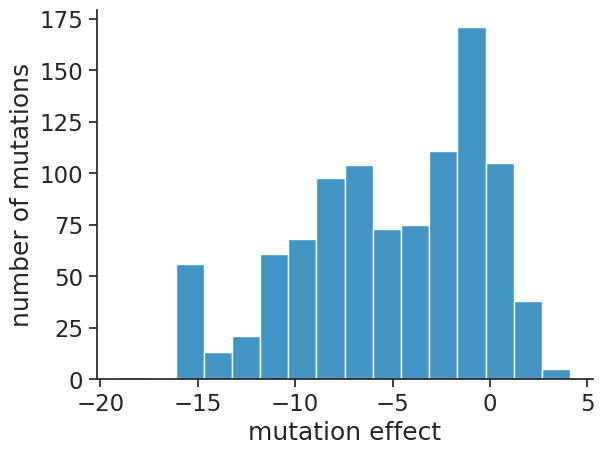

In [5]:
sns.histplot(SigmoidPhenotype_h1.muteffects)
plt.xlabel('mutation effect')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

## Non-reference homolog sequence, and shifted mutational effects

Next, simulate the DNA/protein sequence of second homolog by making a defined number of random amino-acid mutations to the first homolog. Avoid mutations that decrease the latent phenotype by more than two units.

In [6]:
# Input params
random.seed(seed)
non_identical_sites = sorted(random.sample(range(1, len(aaseq_h1)+1), n_non_identical_sites))
aaseq_h2 = ''
geneseq_h2 = ''

# Iterate over each amino acid in the first homolog, and make
# a mutation if indicated.
for (aa_n, aa) in enumerate(aaseq_h1, 1):
    codon = geneseq_h1[(aa_n-1)*3:3*aa_n]
    if aa_n in non_identical_sites:
        mut_aas = [
            mut_aa for mut_aa in AAS_NOSTOP
            if (mut_aa != aa) and (SigmoidPhenotype_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] > min_muteffect_in_bundle)
        ]
        assert len(mut_aas) > 0, aa_n
        mut_aa = random.choice(mut_aas)
        aaseq_h2 += mut_aa
        mut_codon = random.choice(AA_TO_CODONS[mut_aa])
        geneseq_h2 += mut_codon
    else:
        aaseq_h2 += aa
        geneseq_h2 += codon

# Store and summarize results
homolog_seqs = {
    1 : aaseq_h1,
    2 : aaseq_h2
}
n_diffs = sum([aa1 != aa2 for (aa1, aa2) in zip(aaseq_h1, aaseq_h2)])
print('Sequence alignment of homologs h1 and h2:')
print('h1', aaseq_h1)
print('h2', aaseq_h2)
print('Number of aa differences:', n_diffs)
assert len(aaseq_h1) == len(aaseq_h2)
assert aaseq_h2 == str(Bio.Seq.Seq(geneseq_h2).translate())
assert n_diffs == len(non_identical_sites)

Sequence alignment of homologs h1 and h2:
h1 GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG
h2 GSSFSPTVSCCSWWFTLFVRQFTVHSHQDPCCHCTTGWYFSQVCGNSRLG
Number of aa differences: 10


Next, randomly choose a subset of sites that will have shifted mutational effects. Do this independently for sites that are identical and non-identical between homologs, so that we are sure to have shifted sites in each category.

In [7]:
# Non-identical sites
random.seed(seed)
shifted_non_identical_sites = sorted(random.sample(
    non_identical_sites,
    n_shifted_non_identical_sites
))

# Identical sites
identical_sites = [
    i for i in range(1, len(aaseq_h1)+1)
    if i not in non_identical_sites
]
shifted_identical_sites = sorted(random.sample(
    identical_sites,
    n_shifted_identical_sites
))

# Make a list of all shifted sites
shifted_sites = sorted(shifted_identical_sites + shifted_non_identical_sites)
assert len(shifted_sites) == len(set(shifted_sites))
print('Sites with shifts that are...')
print(f'identical (n={len(shifted_identical_sites)}):', ', '.join(map(str, shifted_identical_sites)))
print(f'non-identical (n={len(shifted_non_identical_sites)}):', ', '.join(map(str, shifted_non_identical_sites)))

Sites with shifts that are...
identical (n=5): 7, 16, 17, 19, 26
non-identical (n=3): 11, 12, 25


At each of the above sites, randomly simulate a shift in the effect of each mutation by drawing shifts from a Gaussian distribution.

In [8]:
# TODO possibly have different rate parameters for each site.
def sim_mut_shift(shifted_site, mutation):
    if (not shifted_site) or ('*' in mutation):
        return 0
    else:
        return np.random.normal(loc=0, scale=1.5, size=1)[0]

# Make a dataframe of mutation effects in the first homolog
mut_effects_df = pd.DataFrame.from_dict(
    SigmoidPhenotype_h1.muteffects,
    orient='index',
    columns=['beta_h1']
)
mut_effects_df.reset_index(inplace=True)
mut_effects_df.rename(columns={'index':'mutation'}, inplace=True)
mut_effects_df['wt_aa'] = mut_effects_df['mutation'].str.extract(r'([\w*])\d+[\w*]')
mut_effects_df['site'] = mut_effects_df['mutation'].str.extract(r'[\w*](\d+)[\w*]')
mut_effects_df['site'] = mut_effects_df['site'].astype(int)
mut_effects_df['mut_aa'] = mut_effects_df['mutation'].str.extract(r'[\w*]\d+([\w*])')

# Simulate shifts for all mutations in the pre-defined
# list of shifted sites, ignorning mutations to stop codons
mut_effects_df['shifted_site'] = mut_effects_df['site'].apply(
    lambda x: x in shifted_sites
)
np.random.seed(seed)
mut_effects_df['shift'] = mut_effects_df.apply(
    lambda row: sim_mut_shift(
        row['shifted_site'],
        row['mutation']
    ),
    axis=1
)

# Add column that gives mutation effects in the second homolog
mut_effects_df['beta_h2'] = mut_effects_df['beta_h1'] + mut_effects_df['shift']

# Add columns that give the wildtype amino acids of
# each homolog at each site
for (homolog, seq) in homolog_seqs.items():
    seq_dict = {
        key : []
        for key in ['site', f'aaseq_h{homolog}']
    }
    for (i, aa) in enumerate(seq, 1):
        seq_dict['site'].append(i)
        seq_dict[f'aaseq_h{homolog}'].append(aa)
    seq_df = pd.DataFrame.from_dict(seq_dict)
    mut_effects_df = mut_effects_df.merge(seq_df, on='site')

# Show data for a subset of sites with shifts
mut_effects_df[mut_effects_df['shifted_site'] == True][[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site'
]]

site aaseq_h1 aaseq_h2 mutation    beta_h1     shift    beta_h2  \
120     7        T        T      T7A  -2.826142  1.993818  -0.832324   
121     7        T        T      T7C  -6.883536 -1.155050  -8.038586   
122     7        T        T      T7D -14.643914 -0.474421 -15.118335   
123     7        T        T      T7E  -6.330193 -1.486216  -7.816408   
124     7        T        T      T7F  -7.924448 -1.606224  -9.530672   
..    ...      ...      ...      ...        ...       ...        ...   
515    26        S        S     S26T  -1.060161  0.464347  -0.595814   
516    26        S        S     S26V  -2.942979 -1.358177  -4.301156   
517    26        S        S     S26W -13.127808  2.822089 -10.305719   
518    26        S        S     S26Y -10.869046 -0.339584 -11.208630   
519    26        S        S     S26* -15.000000  0.000000 -15.000000   

     shifted_site  
120          True  
121          True  
122          True  
123          True  
124          True  
..            ...  
515          True  
516          True  
517          True  
518          True  
519          True  

[160 rows x 8 columns]

Plot the distribution of all simulated shifts, excluding mutations to stop codons and sites that have no shifted effects.

Number of mutations with shifts: 152


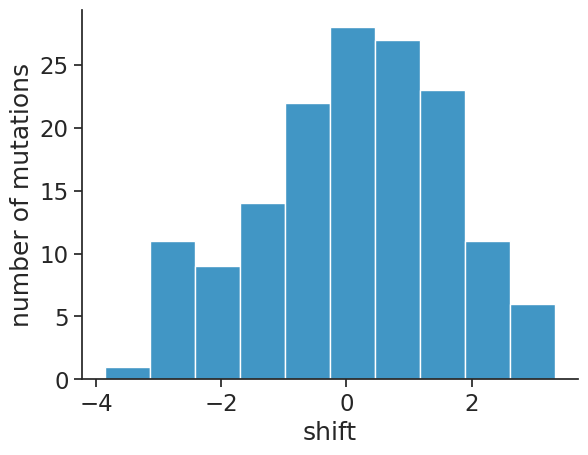

In [9]:
data = mut_effects_df[
    (mut_effects_df['site'].isin(shifted_sites)) &
    ~(mut_effects_df['mutation'].str.contains('\*'))
]
print('Number of mutations with shifts:', len(data))
sns.histplot(data['shift'])
plt.xlabel('shift')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

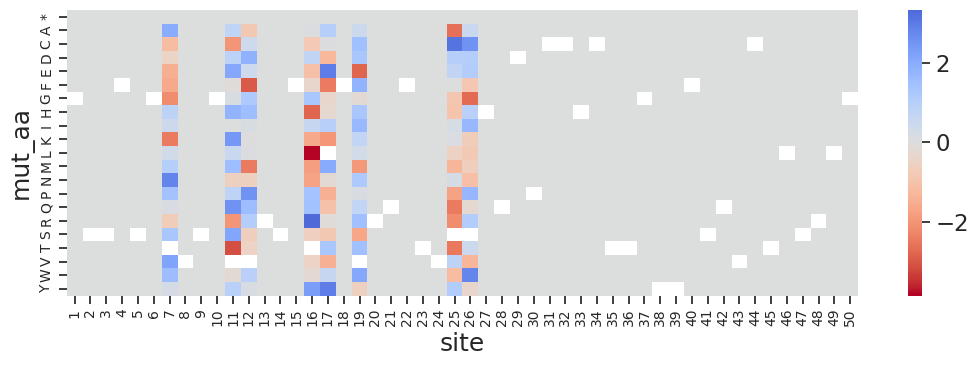

In [10]:

%matplotlib inline

sort_order = sorted([
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","*",
])

fig, ax = plt.subplots(figsize=[11, 4])
sns.heatmap(
    data=mut_effects_df.pivot(index='mut_aa', columns='site', values='shift').loc[sort_order],
    cmap="coolwarm_r",
    center=0,
    ax=ax,
)
ax.set_yticks(
    [s+0.5 for s in range(len(sort_order))],
    labels=sort_order, 
    va="center",
    size=10
)
sites = range(1, 51)
ax.set_xticks(
    [s+0.5 for s in range(len(sites))],
        labels=sites, 
        ha="center",
    rotation=90,
    size=10
)
plt.tight_layout()
plt.show()

Above, we created a `SigmoidPhenotypeSimulator` object for the second homolog by making a copy of the one for the first homolog. This object stores the homolog's wildtype latent phenotype and the latent effects of individual mutations. Below, we update both of these traits based on the simulated shifts from above. To update the wildtype latent phenotype, we will add the effects of all mutations that separate the homologs. In computing this sum, we will use $\beta$ parameters for the second homolog, which already include shifted effects.

In [11]:
# Update individual mutational effects
assert sum(mut_effects_df['mutation'].duplicated()) == 0
for mutation in SigmoidPhenotype_h2.muteffects.keys():
    SigmoidPhenotype_h2.muteffects[mutation] = float(mut_effects_df[mut_effects_df['mutation']==mutation]['beta_h2'])

# Update the wildtype latent phenotype

# grab bundle of mutations separating the two homologs
data = mut_effects_df[
    (mut_effects_df['site'].isin(non_identical_sites)) &
    (mut_effects_df['mut_aa'] == mut_effects_df['aaseq_h2'])
]
# print(data.shape)

wt_latent_phenotype_shift = sum(data['beta_h2'])
SigmoidPhenotype_h2.wt_latent = SigmoidPhenotype_h1.wt_latent + wt_latent_phenotype_shift
print('Characteristics of mutations separating homologs:')
for metric in ['beta_h1', 'shift', 'beta_h2']:
    print(f'Sum of {metric}:', round(sum(data[metric]), 2))
print('Final WT latent phenotype of h2:', round(SigmoidPhenotype_h2.wt_latent, 2))
print('Table of mutations that separate homologs:')
data[[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site', 
]]

Characteristics of mutations separating homologs:
Sum of beta_h1: 2.91
Sum of shift: -3.64
Sum of beta_h2: -0.73
Final WT latent phenotype of h2: 4.27
Table of mutations that separate homologs:


site aaseq_h1 aaseq_h2 mutation   beta_h1     shift   beta_h2  \
111     6        G        P      G6P  0.774939  0.000000  0.774939   
181    10        G        C     G10C -0.666580  0.000000 -0.666580   
201    11        V        C     V11C -0.017674 -2.005404 -2.023077   
235    12        V        S     V12S -0.105813 -0.653983 -0.759795   
257    13        R        W     R13W  2.731780  0.000000  2.731780   
277    14        S        W     S14W  0.764167  0.000000  0.764167   
486    25        S        H     S25H -0.635094 -0.982819 -1.617913   
758    38        Y        W     Y38W  1.638478  0.000000  1.638478   
885    45        T        G     T45G -0.879462  0.000000 -0.879462   
910    46        L        N     L46N -0.690706  0.000000 -0.690706   

     shifted_site  
111         False  
181         False  
201          True  
235          True  
257         False  
277         False  
486          True  
758         False  
885         False  
910         False

All mutations in the second homolog's `SigmoidPhenotypeSimulator` object are defined relative to the wildtype sequence of the first homolog, which we will call the "reference" homolog.
But, to simulate data for the second homolog, we need entries to be relative to the wildtype sequence of the second homolog.
These entries are missing for sites at which the homologs differ in sequence.
For instance, if the wildtype amino acid at site 30 is an A in the first homolog, but is a Y in a second homolog, then the effect of a Y30G is absent from the second homolog's simulator object.

To add these missing entries, we will use a strategy that assumes additivity between mutations at the same site.
For instance, in the above example, a Y30G mutation is defined as the sum of the following two mutations relative to A: A30Y (negated) and A30G.
This approach assumes that mutational effects can be negated, such that A30Y has the opposite effect as Y30A.
It also assumes that mutational effects are additive, such that the effect of Y30G is the sum of the effects of Y30A and A30G.

The below expression defines this approach more explicitly for an arbitrary site.
It uses the notation $\beta_{x,n,z}$ where $x$ and $z$ are amino acids.
For a site $n$, if $aa_{\text{wt}}$ is the site's wildtype amino acid in a non-reference homolog, $aa_{\text{mut}}$ is a mutant amino acid in a variant of that homolog, and $aa_{\text{ref}}$ is the site's wildtype amino acid in the reference homolog, then the mutation's effect is:

$$\beta_{aa_{\text{wt}},n,aa_{\text{mut}}} = \begin{cases}
      \beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{if } aa_{\text{wt}} = aa_{\text{ref}}\\
      -\beta_{aa_{\text{ref}},n,aa_{\text{wt}}} & \text{if } aa_{\text{mut}} = aa_{\text{ref}}\\
      - \beta_{aa_{\text{ref}},n,aa_{\text{wt}}} +\beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{otherwise}\\
\end{cases}$$

The above $\beta$ parameters are effects in the background of the non-reference homolog, such that they account for shifts in mutational effects between homologs.

The below cell adds mutational effects for missing entries using the above strategy.

In [12]:
# Iterate over non-identical sites
# -15 might not accuarately reflect just how deleterious these should be compared to an laten wildtype
# phenotype of 5 (which is seemingly the default).
for site in non_identical_sites:
    
    aa_h1 = aaseq_h1[site-1]
    aa_h2 = aaseq_h2[site-1]
    assert (aa_h1 != aa_h2), site
    
    # Get the effect of the mutation that goes between homologs
    mut_between_homologs = f'{aa_h1}{site}{aa_h2}'
    mut_between_homologs_effect = float(mut_effects_df[
        mut_effects_df['mutation'] == mut_between_homologs
    ]['beta_h2'])
    
    # Iterate over mutant amino acids and add an entry for
    # each one
    for aa_mut in AAS_WITHSTOP:
        if aa_h2 == aa_mut:
            continue
        elif aa_mut == '*':
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = stop_effect
        elif aa_mut == aa_h1:
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect
        else:            
            # Get the effect of the mutation that goes from the
            # reference amino acid to the original mutant amino acid
            mut_from_ref = f'{aa_h1}{site}{aa_mut}'
            mut_from_ref_effect = float(mut_effects_df[
                mut_effects_df['mutation'] == mut_from_ref
            ]['beta_h2'])
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect + mut_from_ref_effect

In [13]:
mut_effects_df.head()

mutation   beta_h1 wt_aa  site mut_aa  shifted_site  shift   beta_h2  \
0      G1A -5.811474     G     1      A         False    0.0 -5.811474   
1      G1C -8.878036     G     1      C         False    0.0 -8.878036   
2      G1D -1.013877     G     1      D         False    0.0 -1.013877   
3      G1E -8.349956     G     1      E         False    0.0 -8.349956   
4      G1F -1.349155     G     1      F         False    0.0 -1.349155   

  aaseq_h1 aaseq_h2  
0        G        G  
1        G        G  
2        G        G  
3        G        G  
4        G        G

## Variant libraries with phenotypes and enrichments


Simulate a library of variants that one might use in an actual experiment. 

Independently simulate variants for both homologs, including two independent libraries per homolog.

In [14]:
CodonVariantTable_h1 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h1,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)
CodonVariantTable_h2 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h2,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)

In [15]:
CodonVariantTable_h1.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

In [16]:
len(CodonVariantTable_h2.barcode_variant_df.barcode.unique())

50000

plot the number of variant support sequences as a histogram

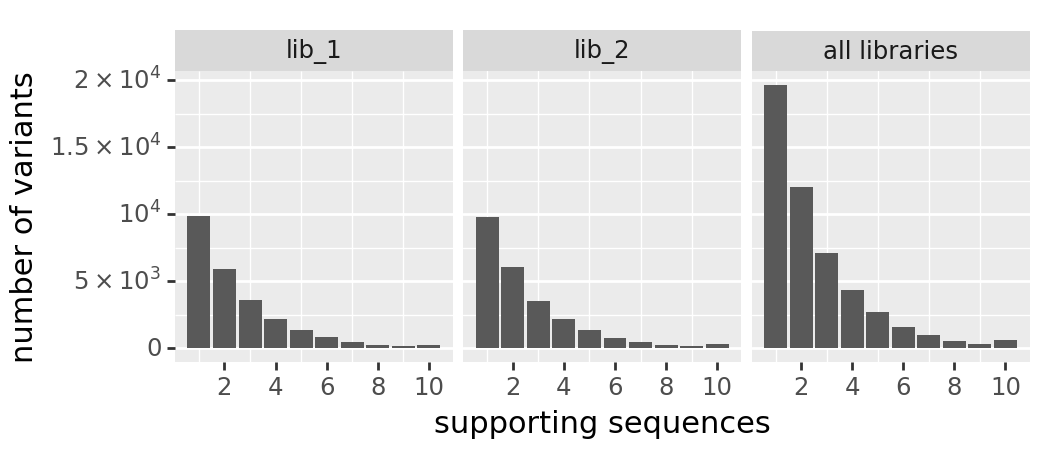

In [17]:
p = CodonVariantTable_h1.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

In [18]:
CodonVariantTable_h2.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

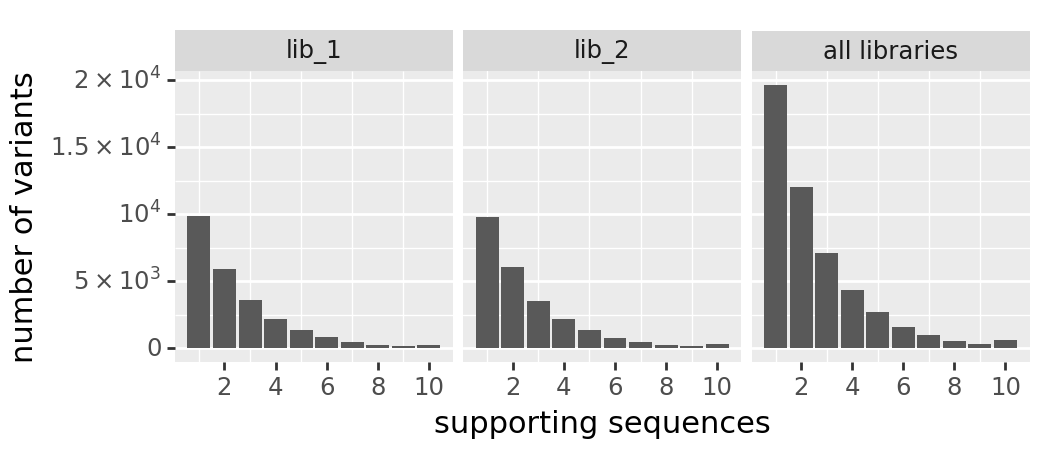

In [19]:
p = CodonVariantTable_h2.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)


For each homolog, simulate latent and observed phenotypes for each variant given the underlying mutation effects from above.

In [20]:
# First homolog
phenotypes_h1 = [
    (SigmoidPhenotype_h1.latentPhenotype, 'latent_phenotype'),
    (SigmoidPhenotype_h1.observedPhenotype, 'observed_phenotype'),
    (SigmoidPhenotype_h1.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h1:
    CodonVariantTable_h1.barcode_variant_df[col_name] = \
        CodonVariantTable_h1.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))
    
# Second homolog
phenotypes_h2 = [
    (SigmoidPhenotype_h2.latentPhenotype, 'latent_phenotype'),
    (SigmoidPhenotype_h2.observedPhenotype, 'observed_phenotype'),
    (SigmoidPhenotype_h2.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h2:
    CodonVariantTable_h2.barcode_variant_df[col_name] = \
        CodonVariantTable_h2.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))

# # Get dataframes listing variants
# v1_df = CodonVariantTable_h1.barcode_variant_df
# v2_df = CodonVariantTable_h2.barcode_variant_df

As in Jesse's notebook, the above computation uses a sigmoid to convert a latent phenotype to an observed one. Below, we plot these sigmoids for the first homolog.

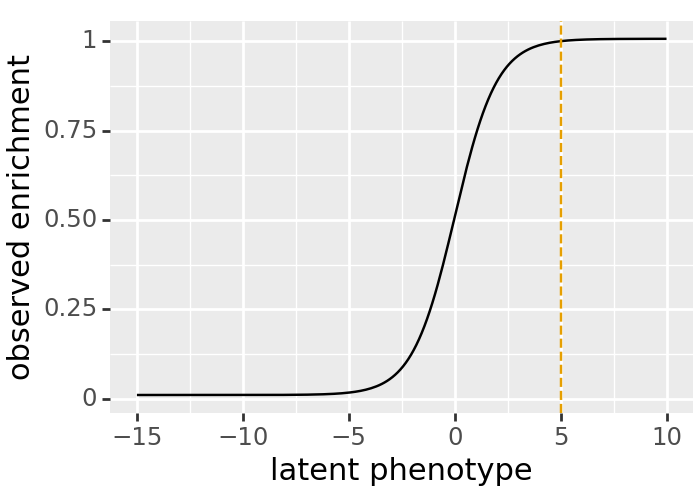

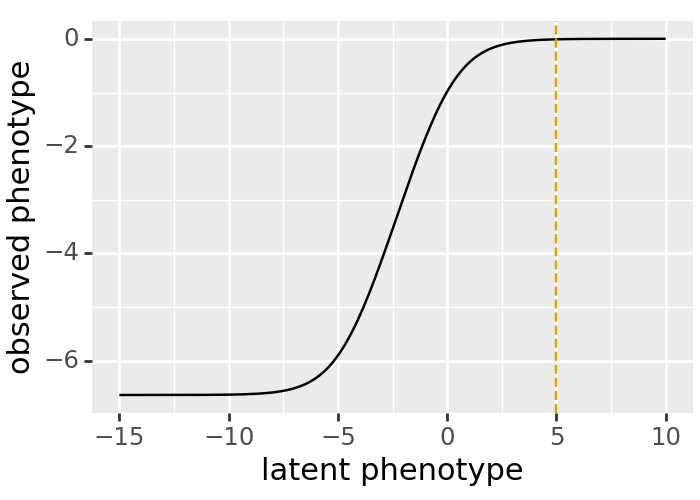

In [21]:

for value in ["enrichment", "phenotype"]:
    p = SigmoidPhenotype_h1.plotLatentVsObserved(value)
    p.draw(show=True)

... and the second homolog:

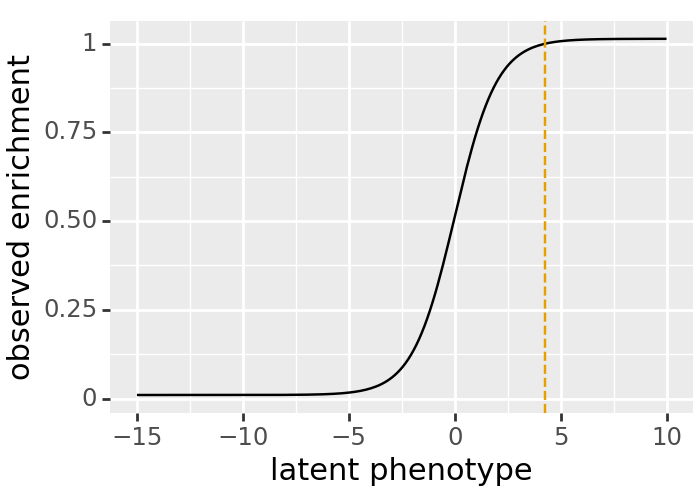

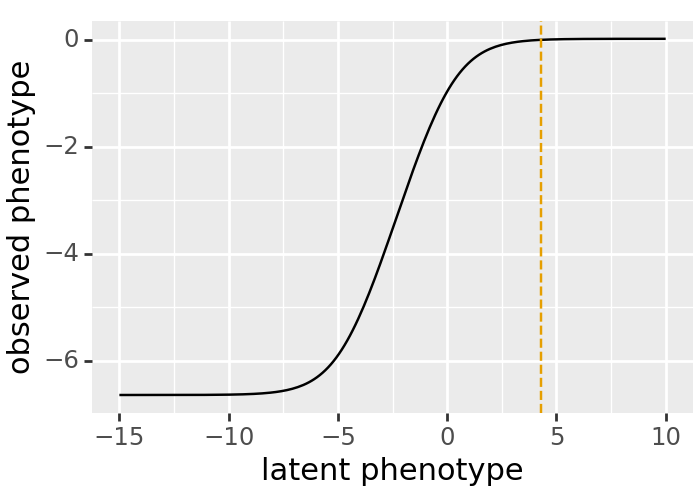

In [22]:
import plotnine
for value in ["enrichment", "phenotype"]:
    p = SigmoidPhenotype_h2.plotLatentVsObserved(value)
    _ = p.draw(show=True)

Show example data for variants for the first homolog.

In [23]:
CodonVariantTable_h1.barcode_variant_df.head()

library           barcode  variant_call_support  \
0   lib_1  AAAAAAGAAATTGGAC                     4   
1   lib_1  AAAAAAGAACCGTACA                     2   
2   lib_1  AAAAAAGGCCGGACGC                     5   
3   lib_1  AAAAACGTTATGAGGC                     1   
4   lib_1  AAAAACTGGGCGACCG                     3   

                                 codon_substitutions  \
0  GTG24CAG TCC25AGG CAT27CCC GAC29TTG CAT33TGT T...   
1                 GTG8CCA CAT27ACG CCG30TAA CTC49CCG   
2                                  GTC19CCG GTC43CAG   
3                                           CGT20TAC   
4                                                      

                          aa_substitutions  n_codon_substitutions  \
0  V24Q S25R H27P D29L H33C S41L C44F S47F                      8   
1                       V8P H27T P30* L49P                      4   
2                                V19P V43Q                      2   
3                                     R20Y                      1   
4                                                               0   

   n_aa_substitutions  latent_phenotype  observed_phenotype  \
0                   8        -23.431108           -6.643856   
1                   4        -16.121890           -6.643842   
2                   2         -8.857904           -6.623548   
3                   1          2.855227           -0.070300   
4                   0          5.000000            0.000000   

   observed_enrichment  
0             0.010000  
1             0.010000  
2             0.010142  
3             0.952440  
4             1.000000

In [24]:
np.all(mut_effects_df['wt_aa'] == mut_effects_df['aaseq_h1'])

True

## Simulate counts

Next, we would like to simulate both pre and post-selection counts of each variant in each experiment in proportion to their ground-truth `"observed_enrichment"`. Post selection counts will be simulated by applying the specified selection bottleneck(s), to the pre-selection counts. 



Note that the counts are simulated proportianlly to the observed *enrichment*, not the observed *phenotype*.
The enrichment for a given variant $v$ is defined as $E(v) = B^{(p(v)-p(wt))}$, where $p(v)$ is the observed phenotype of variant $v$, and $p(wt)$ is the observed phenotype of the wildtype.

 To do this, we will use the `simulate_counts` function from `dms_variants.simulate` and the `compute_scores` function from `dms_variants.codonvarianttable`.

In [25]:
# do this independently for each of the homologs.
counts_h1, counts_h2 = [
    dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={
            "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
            "uniformity": lib_uniformity,
        },
        pre_sample_name="pre-selection",
        post_samples={
            name: {
                "noise": noise,
                "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
                "bottleneck": bottleneck,
            }
            for name, bottleneck in bottlenecks.items()
        },
        seed=seed,
    )
    for variants, phenosimulator in zip(
        [CodonVariantTable_h1, CodonVariantTable_h2], [SigmoidPhenotype_h1, SigmoidPhenotype_h2]
    )
]
CodonVariantTable_h1.add_sample_counts_df(counts_h1)
CodonVariantTable_h2.add_sample_counts_df(counts_h2)

In [26]:
CodonVariantTable_h1.n_variants_df()

library         sample    count
0          lib_1  pre-selection  4725000
1          lib_1   loose_bottle  4925000
2          lib_1   tight_bottle  4625000
3          lib_2  pre-selection  4725000
4          lib_2   loose_bottle  4925000
5          lib_2   tight_bottle  4625000
6  all libraries  pre-selection  9450000
7  all libraries   loose_bottle  9850000
8  all libraries   tight_bottle  9250000

Plot the number of counts for each variant in each sample. The horizontal dashed line shows the total number of variants. The plot shows that all variants are well-sampled in the pre-selection libraries, but that post- selection some variants are sampled more or less. This is expected since selection will decrease and increase the frequency of variants:

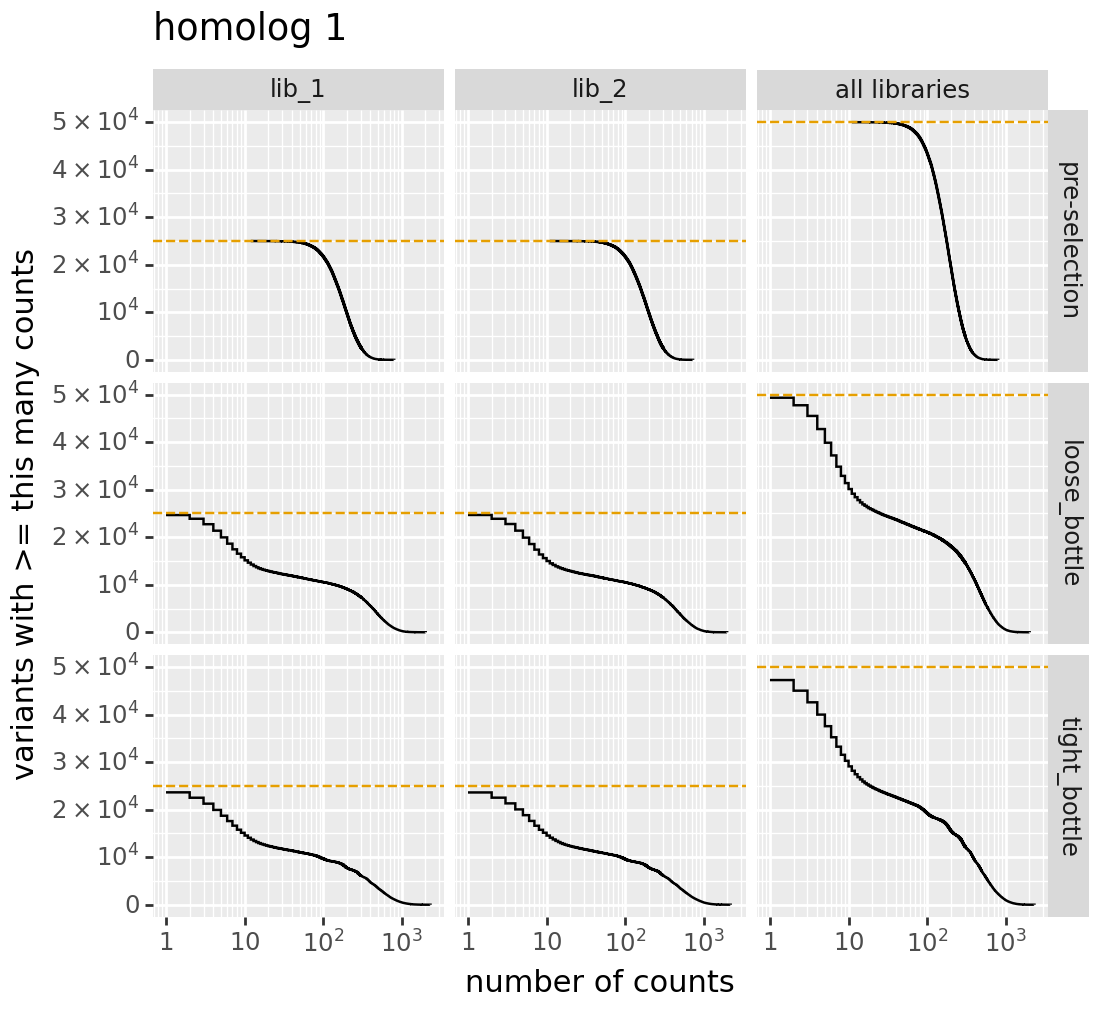

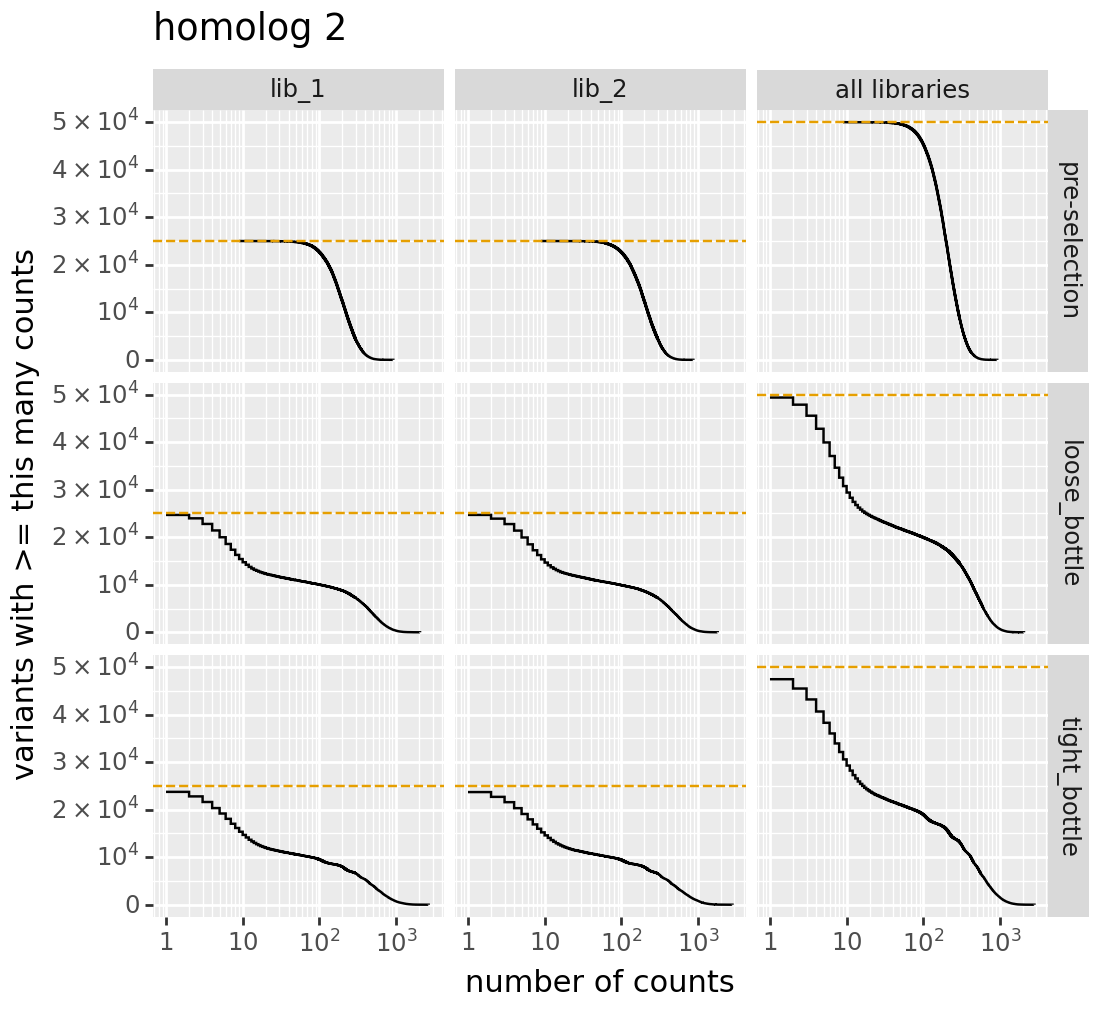

In [27]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotCumulVariantCounts()
    p += labs(title=title)
    _ = p.draw(show=True)

Distribution of the number of amino-acid mutations per variant in each sample. As expected, mutations go down after selection:

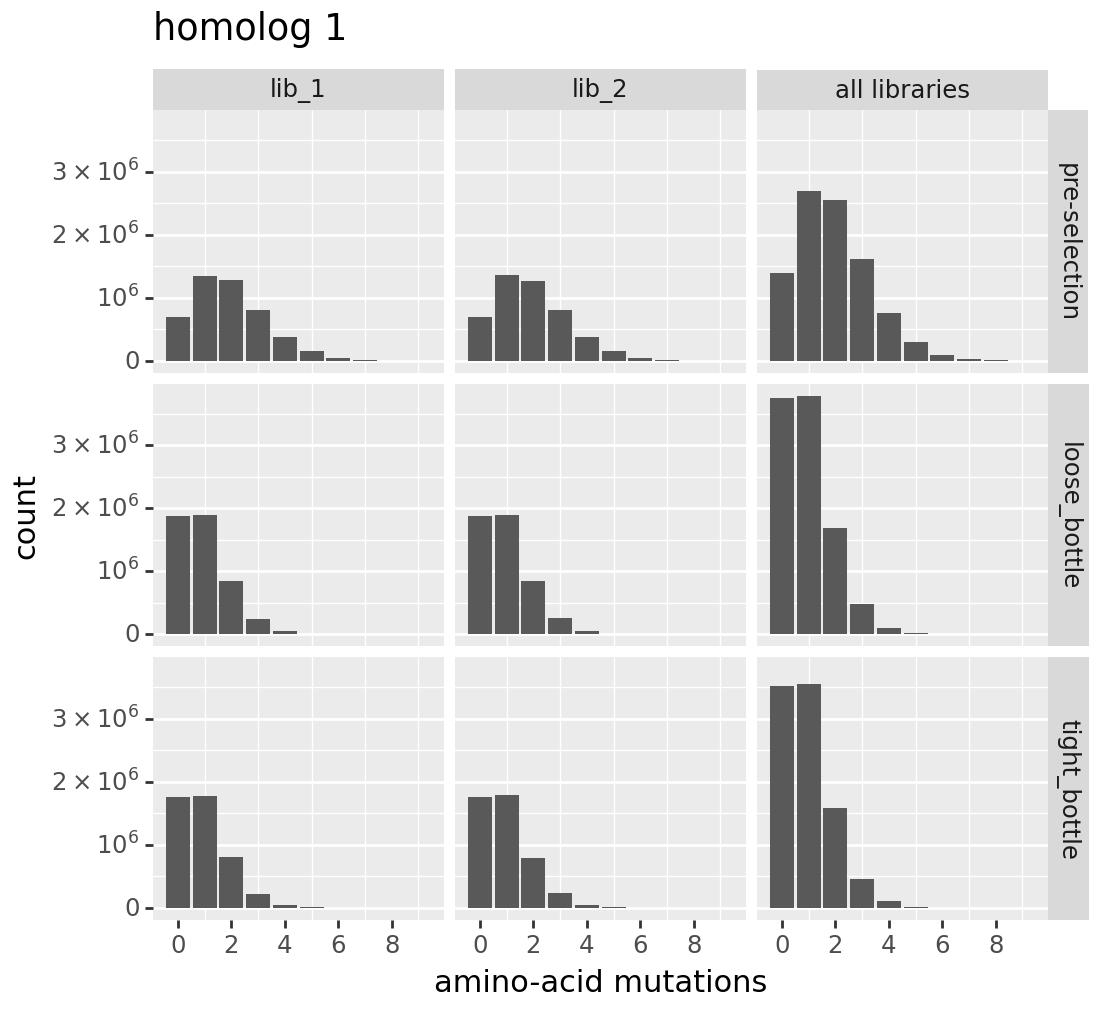

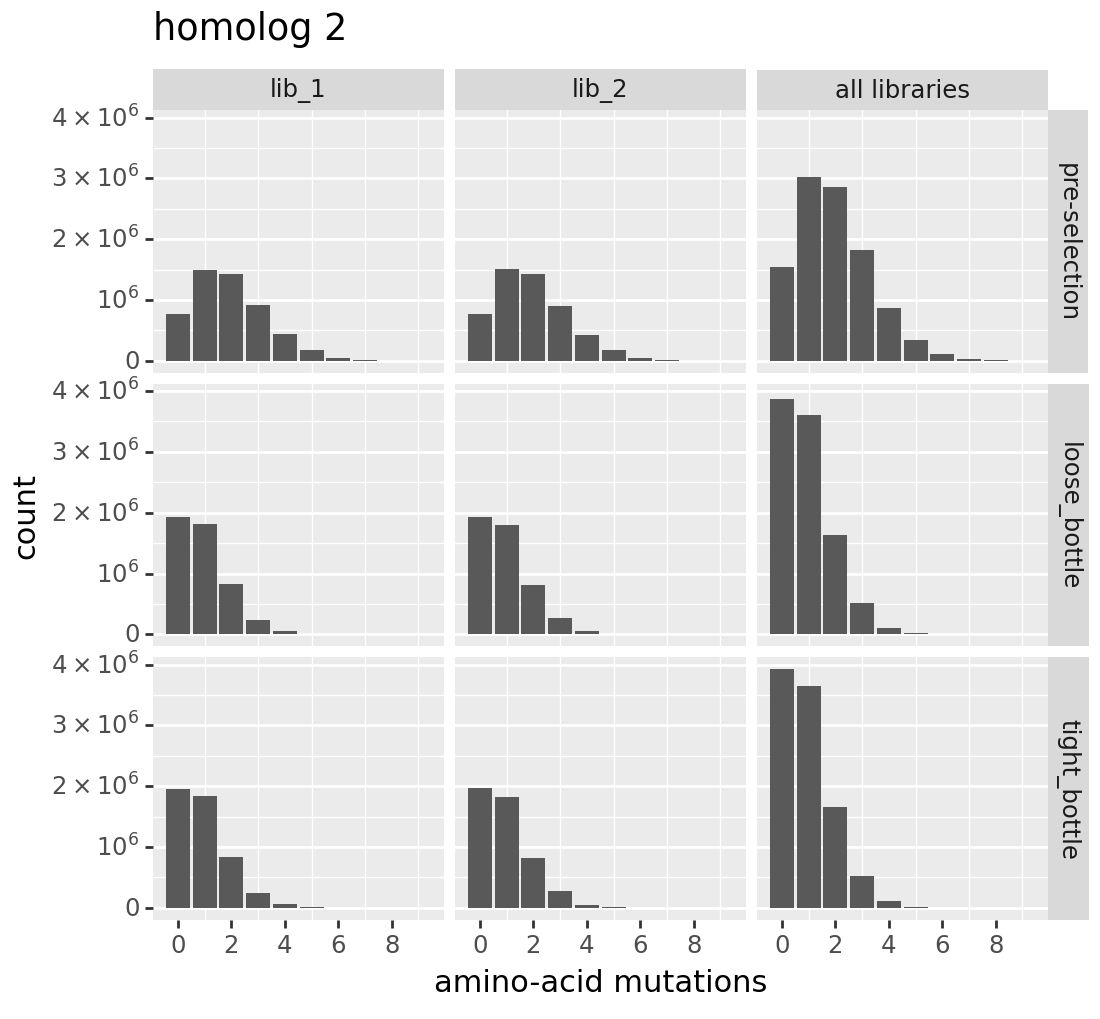

In [28]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotNumMutsHistogram(mut_type="aa")
    p += theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    p += labs(title=title)
    _ = p.draw(show=True)

Plot how thoroughly amino-acid mutations are sampled, doing this separately among all variants and single-mutant variants. The plots below show that the stop mutations are sampled very poorly post-selection because they are eliminated during selection:

<Figure size 640x480 with 0 Axes>

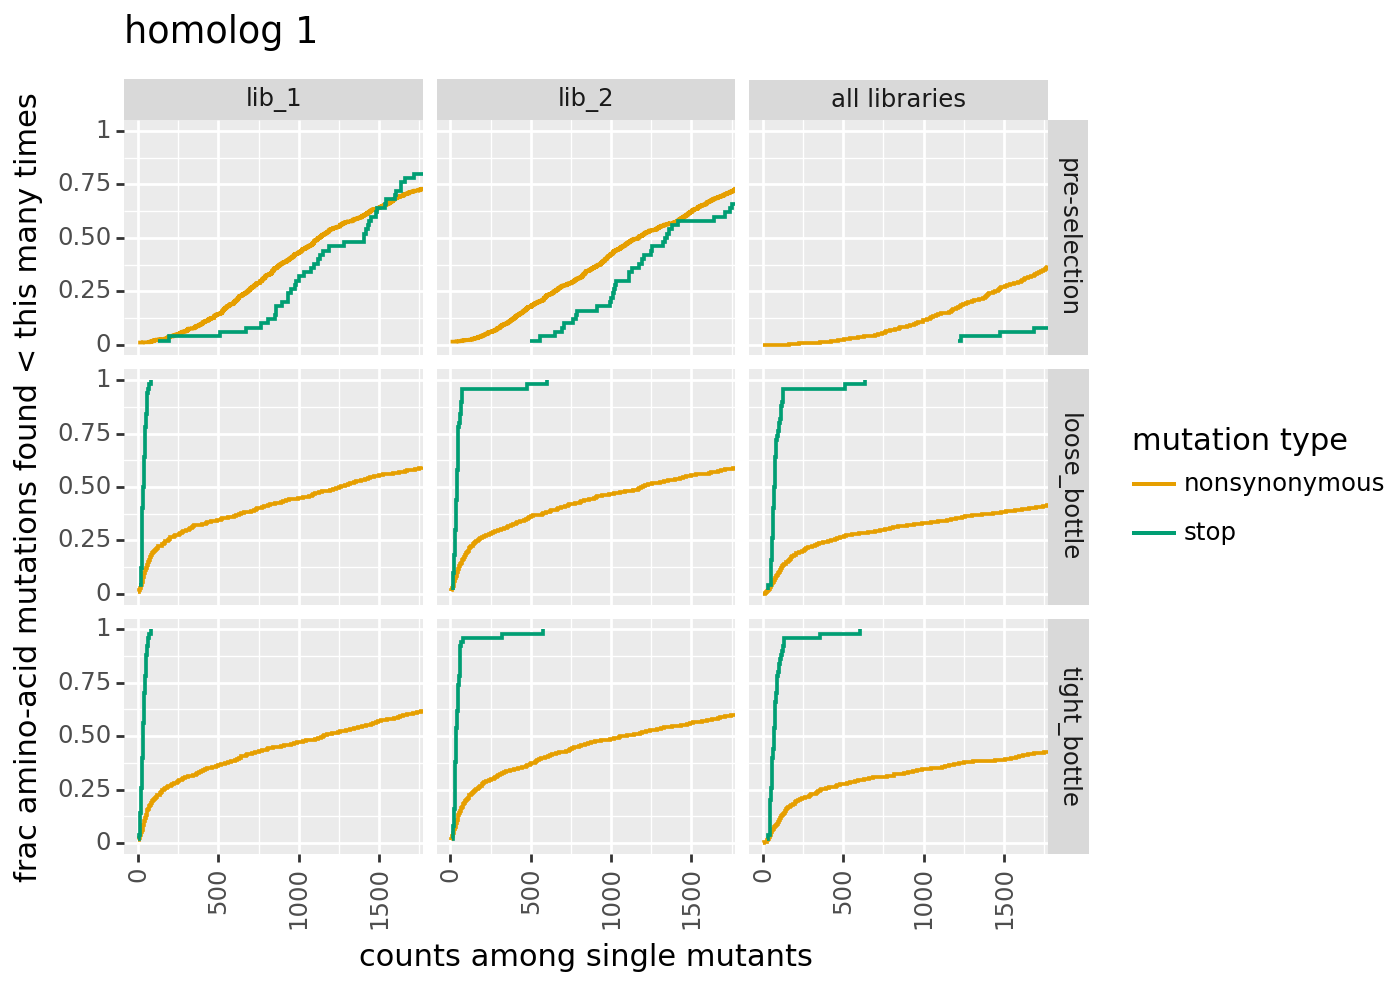

<Figure size 640x480 with 0 Axes>

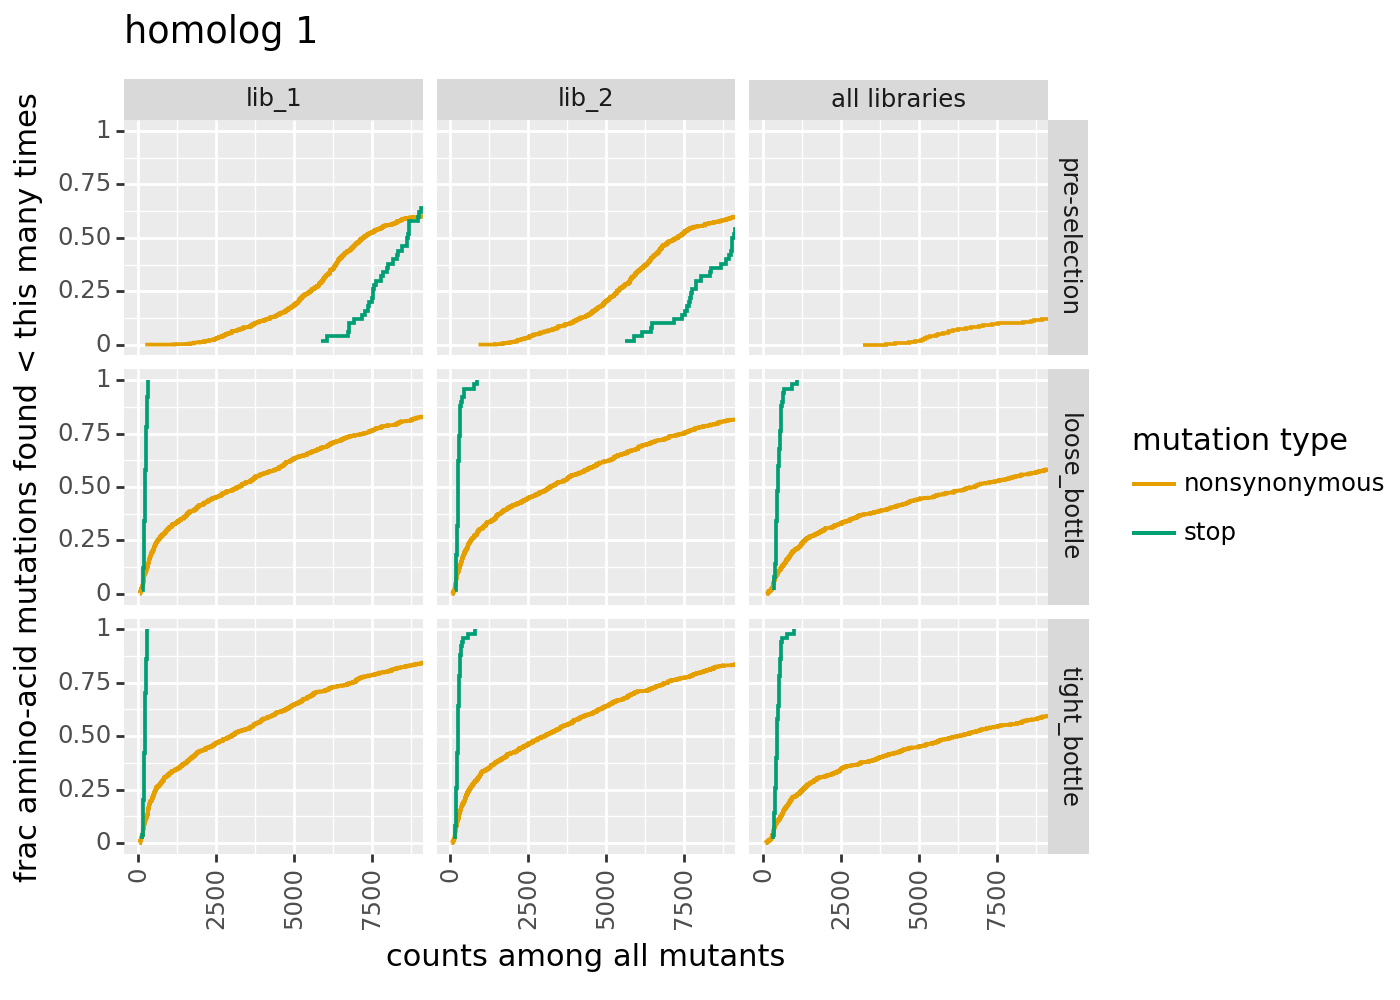

<Figure size 640x480 with 0 Axes>

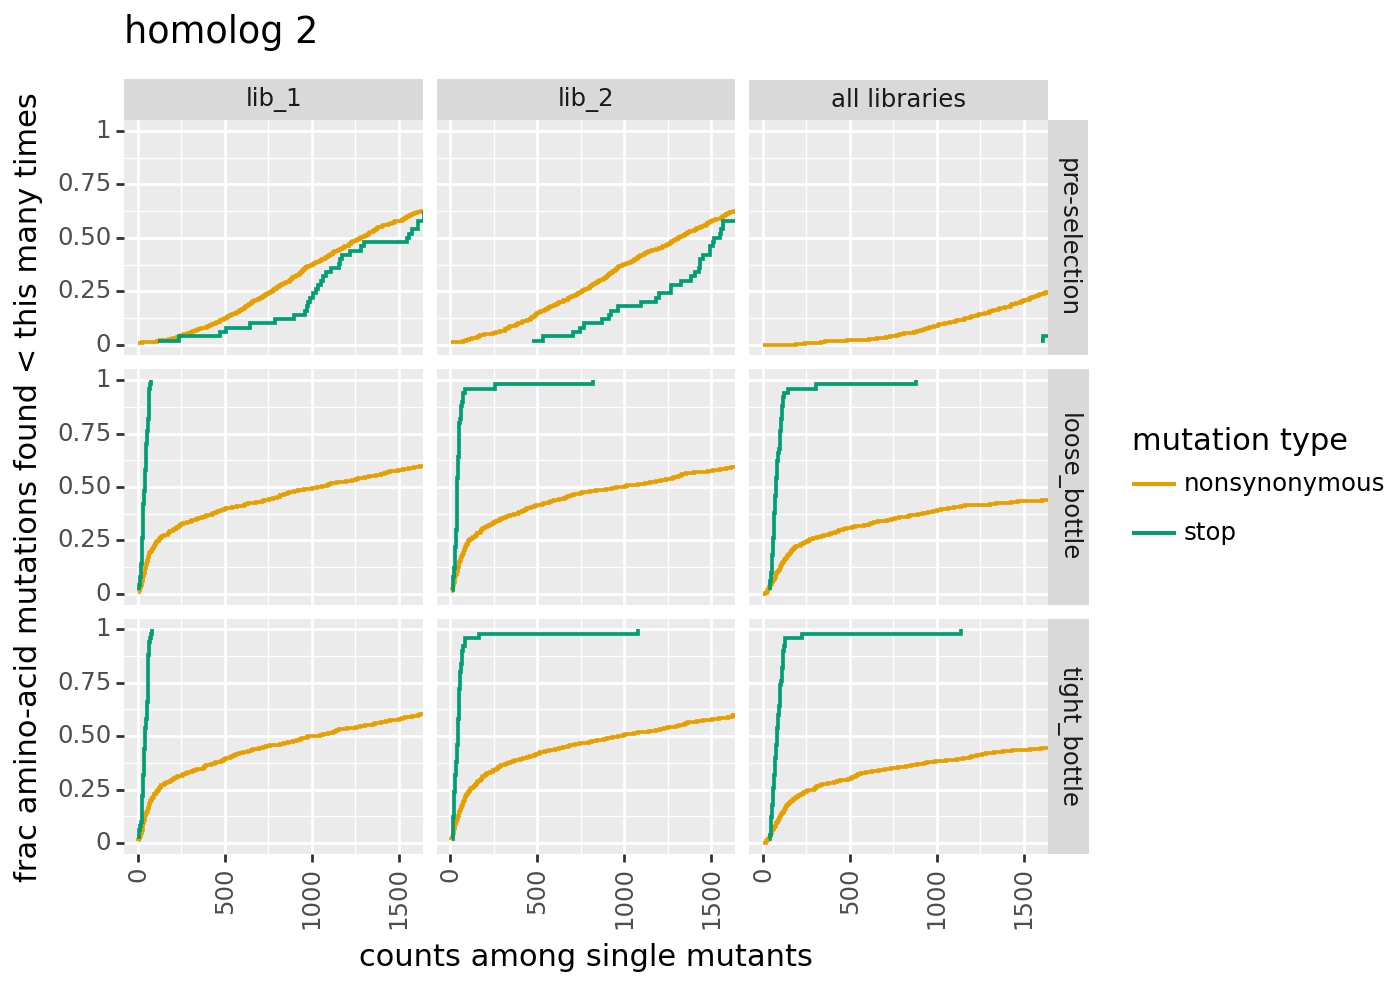

<Figure size 640x480 with 0 Axes>

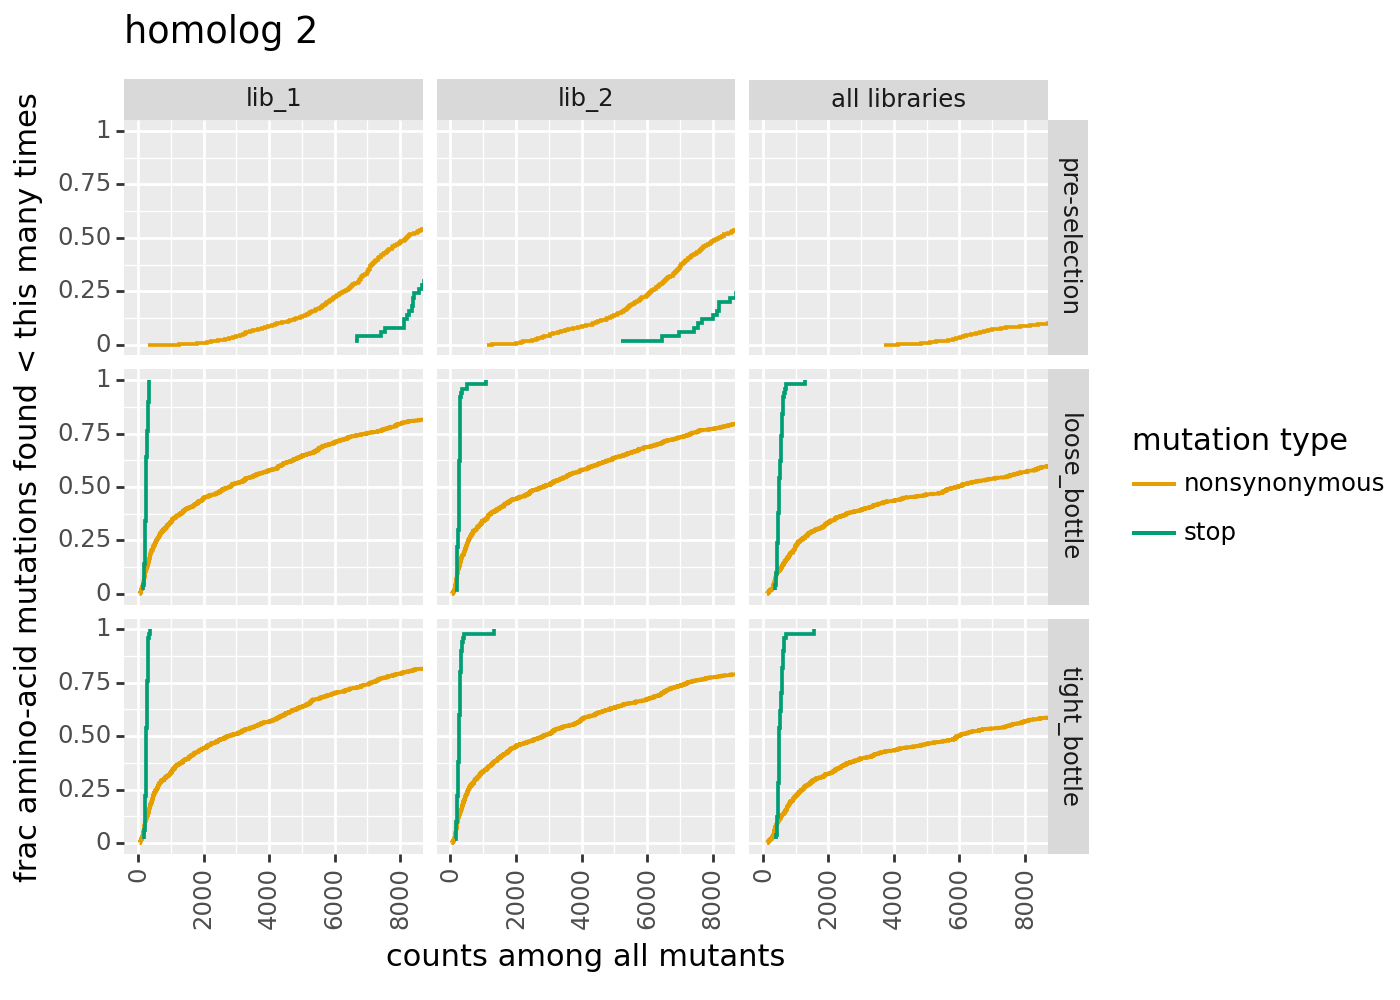

In [29]:
%matplotlib inline
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    for variant_type in ["single", "all"]:
        p = variants.plotCumulMutCoverage(variant_type=variant_type, mut_type="aa")
        p += labs(title=title)
        p += theme(figure_size=(7, 5))
        plt.tight_layout()
        _ = p.draw(show=True)

## Prep training data

Next, we will prepare the training data for fitting our joint `multidms` models.

In [30]:
# <!-- Start by creating training data with ground truth phenotype target. Because the barcode replicates share ground truth phenotypes we can can collapse the counts accross replicates by simple dropping duplicates. -->
# define the required columns and their order
req_cols = ["library", "condition", "aa_substitutions", "func_score_type", "func_score"]
ground_truth_training_set = (
    pd.concat(
        [
            variants.barcode_variant_df[["library", "aa_substitutions", "observed_enrichment", "observed_phenotype"]]
            .drop_duplicates()
            .assign(condition=homolog)
            for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
        ]
    )
    .melt(
        id_vars=["library", "aa_substitutions", "condition"],
        value_vars=["observed_enrichment", "observed_phenotype"],
        var_name="func_score_type",
        value_name="func_score",
    )
    [req_cols]
    .astype({c:str for c in req_cols[:-1]})
)
# Collapsing counts accross replicate `aa_substituitions` _before_ computing the functional score.
bottle_cbf = pd.concat(
    [
        (
            variants
            .func_scores("pre-selection", by="aa_substitutions", libraries=libs, syn_as_wt=True)
            .assign(condition=homolog)
            .rename({"post_sample":"func_score_type"}, axis=1)
            # .replace({"loose_bottle":"loose_bottle_cbf", "tight_bottle":"tight_bottle_cbf"})
            [req_cols]
            .astype({c:str for c in req_cols[:-1]})
        )
        for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
    ]
)
# Compute functional score before collapsing variants
# bottle_caf = pd.concat(
#     [
#         variants
#         .func_scores("pre-selection", by="barcode", libraries=libs, syn_as_wt=True)
#         .assign(condition=homolog)
#         .rename({"post_sample":"func_score_type"}, axis=1)
#         .replace({"loose_bottle":"loose_bottle_caf", "tight_bottle":"tight_bottle_caf"})
#         [req_cols]
#         .astype({c:str for c in req_cols[:-1]})
#         .groupby(req_cols[:-1], as_index=False)
#         .mean()
#         .dropna() # not that this transforms the groups to include all variants in all lib/condition combos. need to drop those
#         for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
#     ]
# )

def classify_variant(aa_subs):
    if "*" in aa_subs:
        return "stop"
    elif aa_subs == "":
        return "wildtype"
    elif len(aa_subs.split()) == 1:
        return "1 nonsynonymous"
    elif len(aa_subs.split()) > 1:
        return ">1 nonsynonymous"
    else:
        raise ValueError(f"unexpected aa_subs: {aa_subs}")

func_scores = (
    pd.concat([ground_truth_training_set, bottle_cbf])
    .assign(variant_class = lambda x: x['aa_substitutions'].apply(classify_variant))
)

print(func_scores.groupby(["library", "func_score_type"]).size(), "\n")
func_scores.head()

library  func_score_type    
lib_1    loose_bottle           30281
         observed_enrichment    30281
         observed_phenotype     30281
         tight_bottle           30281
lib_2    loose_bottle           30263
         observed_enrichment    30263
         observed_phenotype     30263
         tight_bottle           30263
dtype: int64 



library condition                         aa_substitutions  \
0   lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1   lib_1        h1                       V8P H27T P30* L49P   
2   lib_1        h1                                V19P V43Q   
3   lib_1        h1                                     R20Y   
4   lib_1        h1                                            

       func_score_type  func_score     variant_class  
0  observed_enrichment    0.010000  >1 nonsynonymous  
1  observed_enrichment    0.010000              stop  
2  observed_enrichment    0.010142  >1 nonsynonymous  
3  observed_enrichment    0.952440   1 nonsynonymous  
4  observed_enrichment    1.000000          wildtype

Plot a pairplot to see how targets compare.

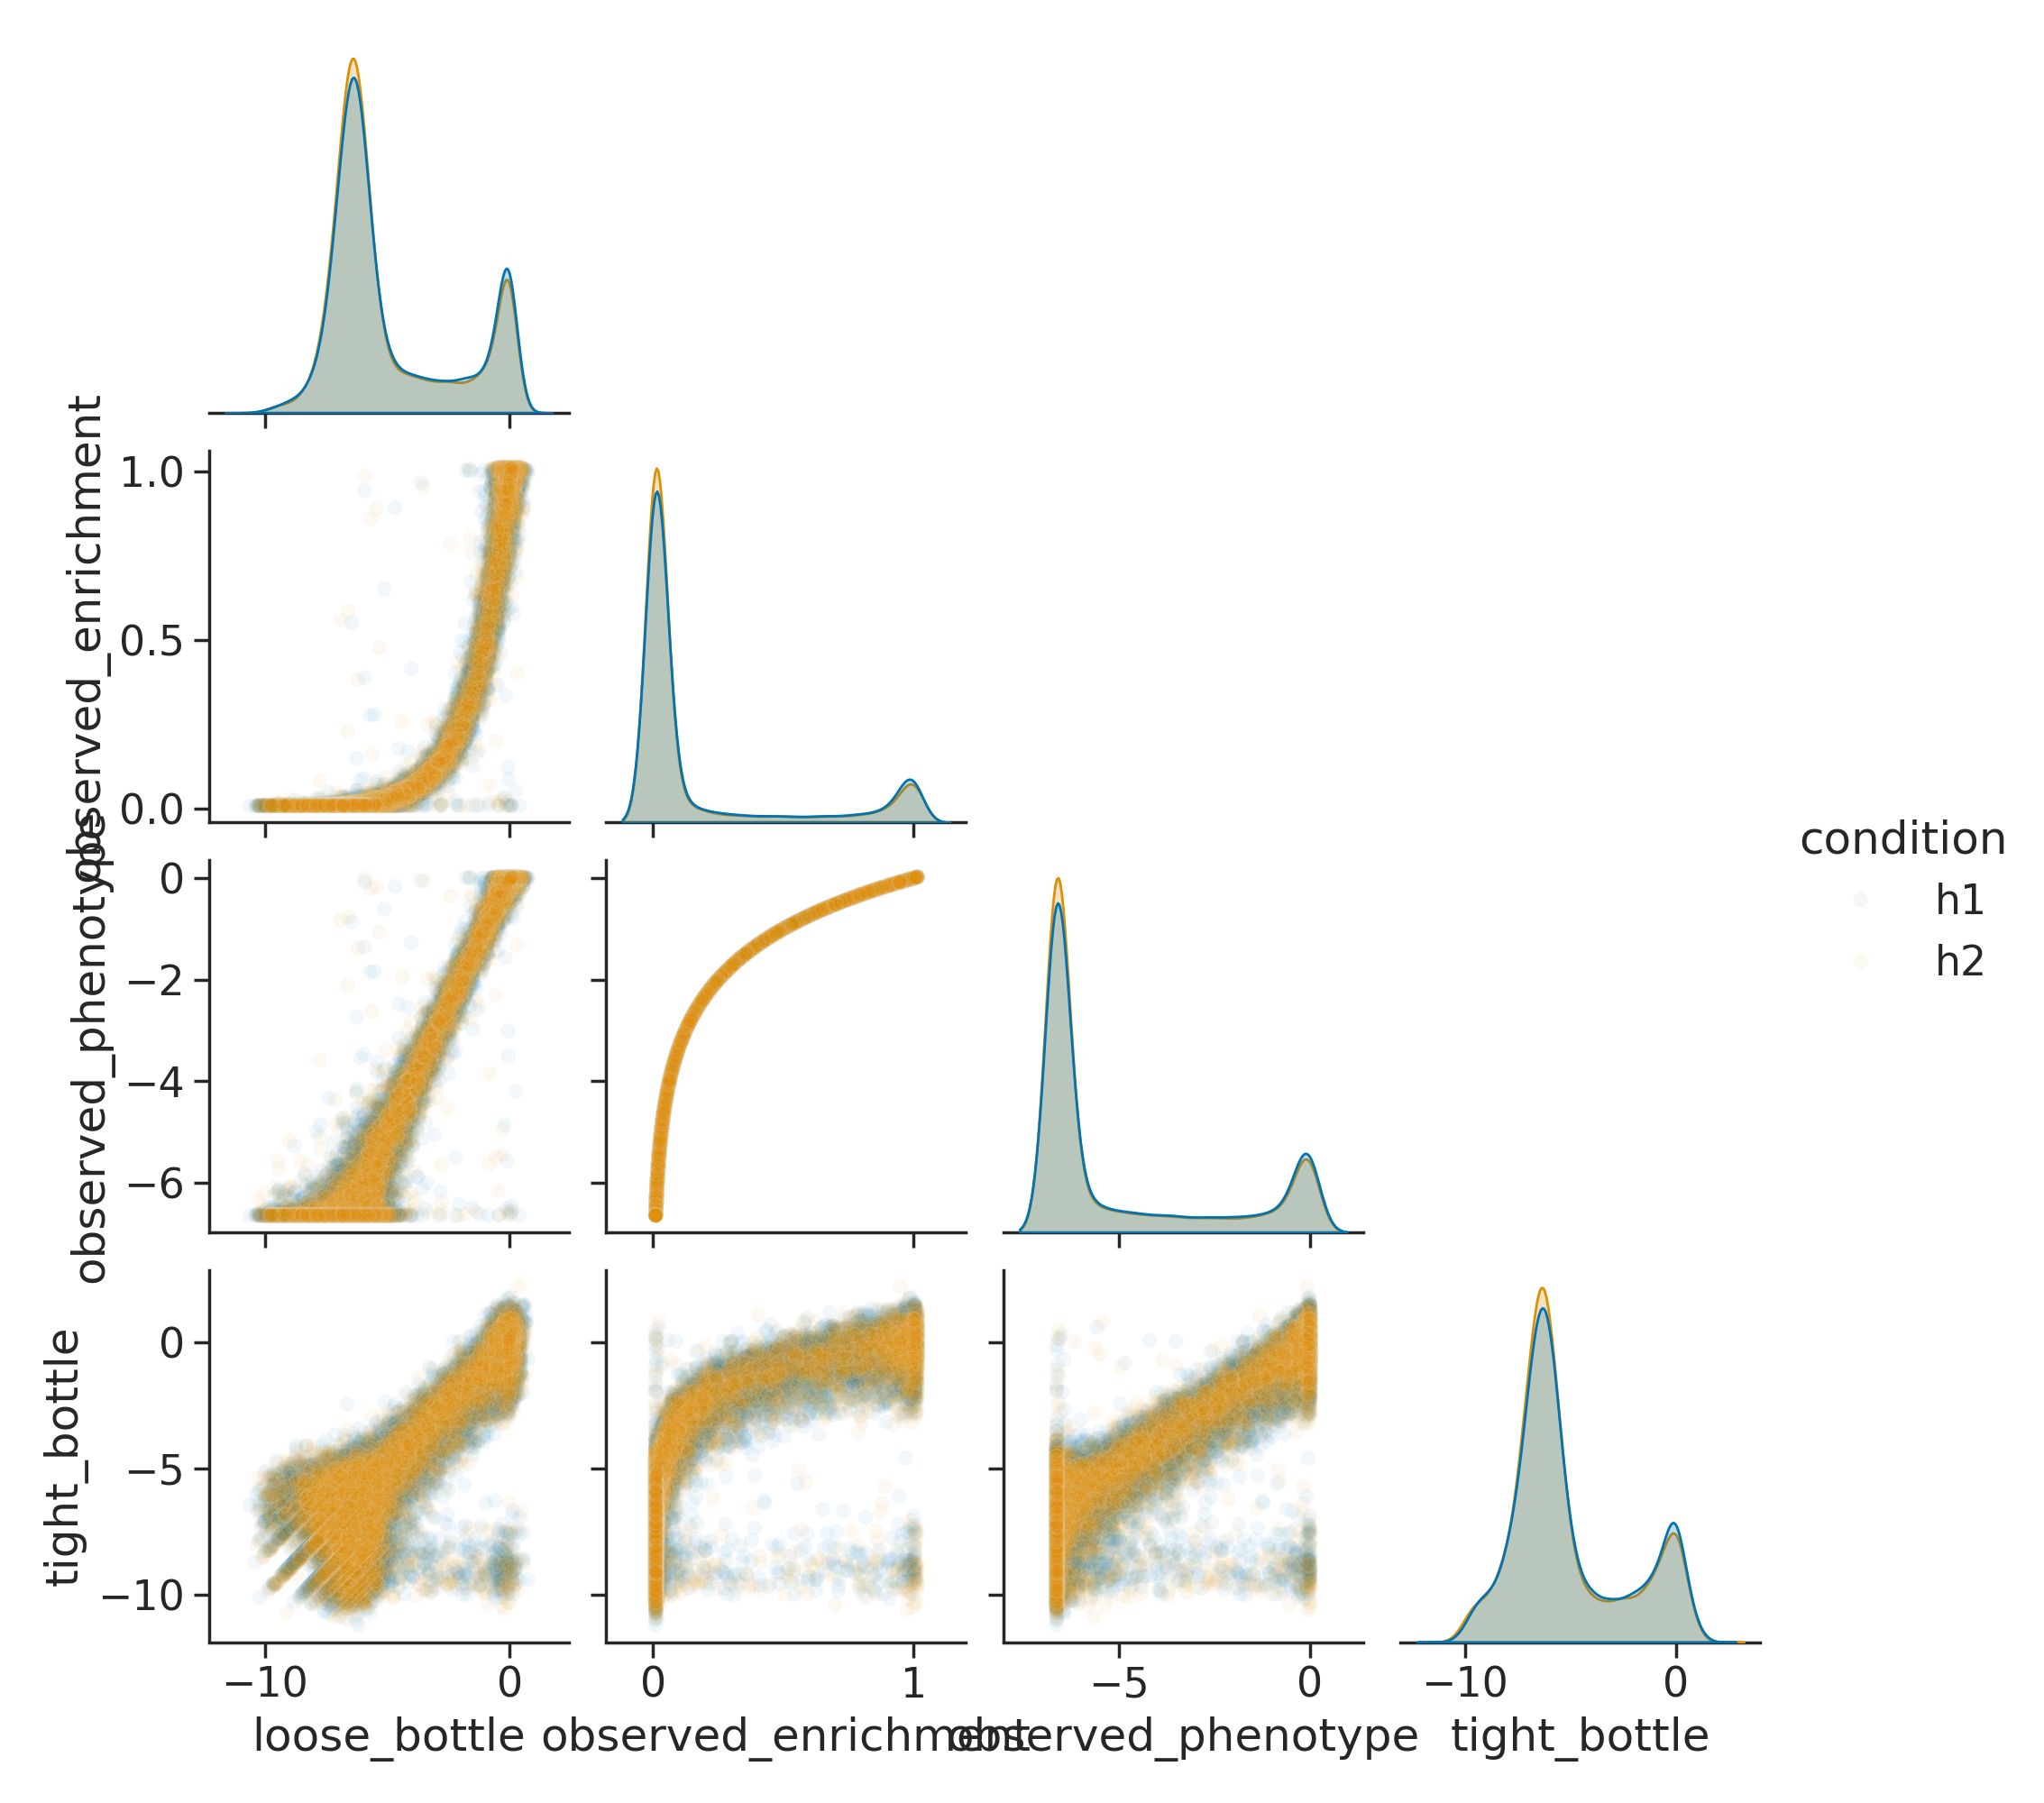

In [31]:
sns.pairplot(
    (
        func_scores
        .pivot(
            index=["library", "condition", "aa_substitutions", "variant_class"],
            columns="func_score_type",
            values="func_score"
        )
        .reset_index()
        # .rename(
        #     {
        #         "observed_enrichment":"true\nenrichment",
        #         "observed_phenotype":"true\nphenotype",
        #         "tight_bottle_cbf":"tight bottle\n CBF",
        #         "loose_bottle_cbf":"loose bottle\nCBF",
        #     },
        #     axis=1
        # )
    ),  
    hue='condition',
    plot_kws = {"alpha":0.05},
    # vars = ['true\nenrichment', 'true\nphenotype', 'tight bottle\n CBF', 'loose bottle\nCBF', 'tight bottle\nCAF', 'loose bottle\nCAF'],
    corner=True
)

Plot the functional scores distributions of the bottleneck counts-computed functional scores.

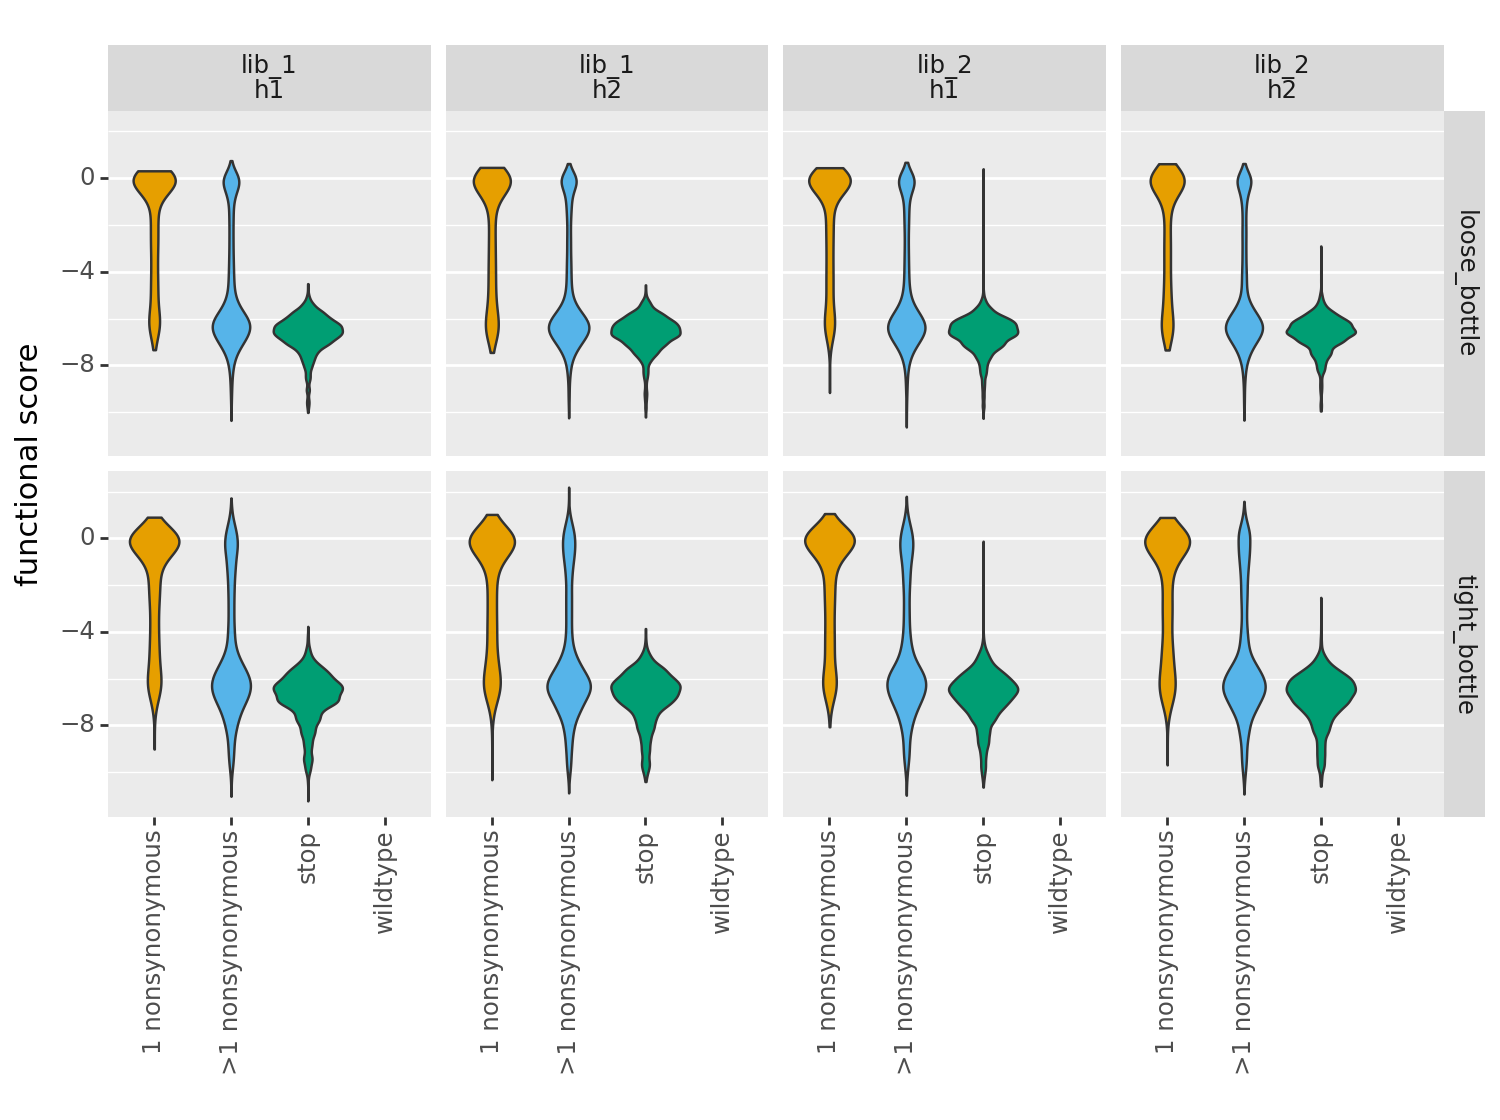

In [32]:
# for func_scores, title in zip([func_scores_h1, func_scores_h2], ['homolog 1', 'homolog 2']):
# for title, df in func_scores.group
p = (
    ggplot(
        func_scores.query("(func_score_type != 'observed_phenotype') & (func_score_type != 'observed_enrichment')"), 
        aes("variant_class", "func_score")
    )
    + geom_violin(aes(fill="variant_class"))
    + ylab("functional score")
    + xlab("")
    + facet_grid("func_score_type ~ library + condition")
    + theme(
        figure_size=(3.75 * len(libs), 1.4 * len(func_scores["func_score_type"].unique())),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + scale_fill_manual(values=CBPALETTE[1:], guide=False)
    # + labs(title=title)
)
_ = p.draw(show=True)

## multidms fitting

Create data fitting objects for each of the library replicates. We do this by grabbing the corect functional scores slices, and feeding them into the `multidms.Data` constructor. Note that we will not be fitting to the enrichment ground truth scores as those are simply the exponential of the phenotype.

In [33]:
data_objects = [
    multidms.Data(
        fs_df, 
        reference="h1", 
        alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
        verbose=True,
        name = f"{lib}_{target}_func_score"
    )
    for (lib, target), fs_df in func_scores.groupby(['library', 'func_score_type'])
    if "enrichment" not in target
]


inferring site map for h1


  0%|          | 0/15096 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15185 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


inferring site map for h1


  0%|          | 0/15096 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15185 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15096 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15185 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15086 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15177 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15086 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15177 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


inferring site map for h1


  0%|          | 0/15086 [00:00<?, ?it/s]

inferring site map for h2


  0%|          | 0/15177 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for h1
is reference, skipping
Converting mutations for h2


We now have the following datasets to fit to:

In [34]:
data_objects

[Data(lib_1_loose_bottle_func_score),
 Data(lib_1_observed_phenotype_func_score),
 Data(lib_1_tight_bottle_func_score),
 Data(lib_2_loose_bottle_func_score),
 Data(lib_2_observed_phenotype_func_score),
 Data(lib_2_tight_bottle_func_score)]

Next, we'll fit a set of models to each of the datasets, across a sweep of lasso regularization coefficients using `multidms.fit_models`.

In [106]:
model_collection_params = {
    # "dataset": [data_objects[0]],
    "dataset": data_objects,
    "num_training_steps" : [1],
    "iterations_per_step": [10000], # Small number of iterations for purposes of this example
    "scale_coeff_lasso_shift": [0.0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 3e-4],
    # "scale_coeff_lasso_shift": [2e-5],
    "init_beta_naught" : [5.0],
    # "init_theta_scale" : [6.0],
    # "init_theta_bias" : [-6.0],
    # "scale_coeff_lasso_shift": [0],
    "scale_coeff_ridge_beta" : [0.0, 5e-7], # we've found that a small ridge penalty is really quite helpful for the model to not get stuck at weird local minima
}
_, _, fit_collection = multidms.model_collection.fit_models(model_collection_params, n_threads=24)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun 

We now have the following models fit:

In [107]:
fit_collection["infer_beta_naught"] = [round(float(row.model.params['beta_naught'][0]), 2) for _, row in fit_collection.iterrows()]
fit_collection["measurement_type"] = fit_collection["dataset_name"].str.split("_").str[2:4].str.join("_")
fit_collection["library"] = fit_collection["dataset_name"].str.split("_").str[0:2].str.join("_")
# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
fit_collection["measurement_type"] = pd.Categorical(
    fit_collection["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)

In [108]:
# fit_collection_subset = (
#     fit_collection
#     .query("scale_coeff_ridge_beta == 1e-6")
#     # .query("library == 'lib_1'")
#     # [["measurement_type", "library", "scale_coeff_ridge_beta", "init_beta_naught", "infer_beta_naught"]]
#     [["measurement_type", "library", "init_beta_naught", "infer_beta_naught"]]
# )
# fit_collection_subset

In [109]:
cols = [
    # unique combinations of these make up the model collection that we've fit
    "library", # replicate library,
    "measurement_type", # type of functional score
    "lasso", # lasso coefficient of model

    # variant defining columns
    "aa_substitutions", # variant substitutions
    "var_wrt_ref", # variant substitutions relative to reference
    "condition", # homolog

    "measured_phenotype", # the actual target functional score for training, in multidms, this is "func_score"
    "measured_enrichment", # 2 ** measured_func_score

    "predicted_latent_phenotype", # predicted latent phenotype
    "predicted_phenotype", # predicted observed phenotype - or in jesse's case, the "observed phenotype"
    "predicted_enrichment", # predicted enrichment

    "true_latent_phenotype", # true latent phenotype
    "true_observed_phenotype", # true observed phenotype
    "true_enrichment", # true enrichment
]

First, let's grab the model predictions of latent, and observed phenotypes for each of the datasets using `multidms.Model.get_variants_df`.


In [110]:
Latent_funcs = {
    "h1" : SigmoidPhenotype_h1.latentPhenotype,
    "h2" : SigmoidPhenotype_h2.latentPhenotype
}

Observed_funcs = {
    "h1" : SigmoidPhenotype_h1.observedPhenotype,
    "h2" : SigmoidPhenotype_h2.observedPhenotype
}

Enrichment_funcs = {
    "h1" : SigmoidPhenotype_h1.observedEnrichment,
    "h2" : SigmoidPhenotype_h2.observedEnrichment
}

variants_df = pd.concat(
    [
        row.model.get_variants_df(phenotype_as_effect=True)
        .assign(
            # library="_".join(row.dataset_name.split("_")[0:2]),
            library=row.library,
            # measurement_type="_".join(row.dataset_name.split("_")[2:]),
            measurement_type=row.measurement_type,
            lasso=row.scale_coeff_lasso_shift,
            ridge=row.scale_coeff_ridge_beta
        )
        .rename(
            {
                "predicted_func_score": "predicted_phenotype", # wt is zero-centered (as_effect=True)
                "predicted_latent": "predicted_latent_phenotype",
                "func_score" : "measured_phenotype",
            },
            axis=1,
        )
        # add enrichments
        .assign(
            predicted_enrichment = lambda x: 2**x['predicted_phenotype'],
            measured_enrichment = lambda x: 2**x['measured_phenotype'],
            fit_idx = idx
        )
        for idx, row in fit_collection.iterrows()
    ]
)
variants_df  = pd.concat(
    [
        variants_df.query("condition == @homolog")
        .assign(
            true_latent_phenotype = lambda x: x['aa_substitutions'].map(Latent_funcs[homolog]),
            true_observed_phenotype = lambda x: x['aa_substitutions'].map(Observed_funcs[homolog]),
            true_enrichment = lambda x: x['aa_substitutions'].map(Enrichment_funcs[homolog]),
        )
        for homolog in ['h1', 'h2']
    ]
)
variants_df[cols].round(2).head()


library measurement_type    lasso aa_substitutions     var_wrt_ref  \
0   lib_1     loose_bottle 0.00E+00             Q28P            Q28P   
1   lib_1     loose_bottle 0.00E+00             G50E            G50E   
2   lib_1     loose_bottle 0.00E+00             R48G            R48G   
3   lib_1     loose_bottle 0.00E+00    S3R G10Y L49H   S3R G10Y L49H   
4   lib_1     loose_bottle 0.00E+00   F18T Q21E C44T  F18T Q21E C44T   

  condition  measured_phenotype  measured_enrichment  \
0        h1           -2.60E-01             8.40E-01   
1        h1            8.00E-02             1.05E+00   
2        h1           -2.66E+00             1.60E-01   
3        h1           -6.58E+00             1.00E-02   
4        h1           -6.19E+00             1.00E-02   

   predicted_latent_phenotype  predicted_phenotype  predicted_enrichment  \
0                   -2.52E+00            -2.90E-01              8.20E-01   
1                   -1.13E+00            -6.00E-02              9.60E-01   
2                   -5.15E+00            -2.69E+00              1.60E-01   
3                   -1.32E+01            -6.61E+00              1.00E-02   
4                   -1.24E+01            -6.61E+00              1.00E-02   

   true_latent_phenotype  true_observed_phenotype  true_enrichment  
0               1.70E+00                -2.30E-01         8.50E-01  
1               3.48E+00                -3.00E-02         9.80E-01  
2              -1.72E+00                -2.63E+00         1.60E-01  
3              -1.23E+01                -6.64E+00         1.00E-02  
4              -1.08E+01                -6.64E+00         1.00E-02

In [111]:
fit_collection["variant_phenotype_corr"] = np.nan
for idx, model_variants_df in variants_df.groupby(["fit_idx"]):
    fit_collection.loc[idx, "variant_phenotype_corr"] = model_variants_df["predicted_phenotype"].corr(model_variants_df["measured_phenotype"])
fit_collection[["scale_coeff_lasso_shift", "dataset_name", "variant_phenotype_corr"]].head()

scale_coeff_lasso_shift                   dataset_name  \
0                0.00E+00  lib_1_loose_bottle_func_score   
1                0.00E+00  lib_1_loose_bottle_func_score   
2                1.00E-05  lib_1_loose_bottle_func_score   
3                1.00E-05  lib_1_loose_bottle_func_score   
4                2.00E-05  lib_1_loose_bottle_func_score   

   variant_phenotype_corr  
0                9.69E-01  
1                9.69E-01  
2                9.69E-01  
3                9.69E-01  
4                9.69E-01

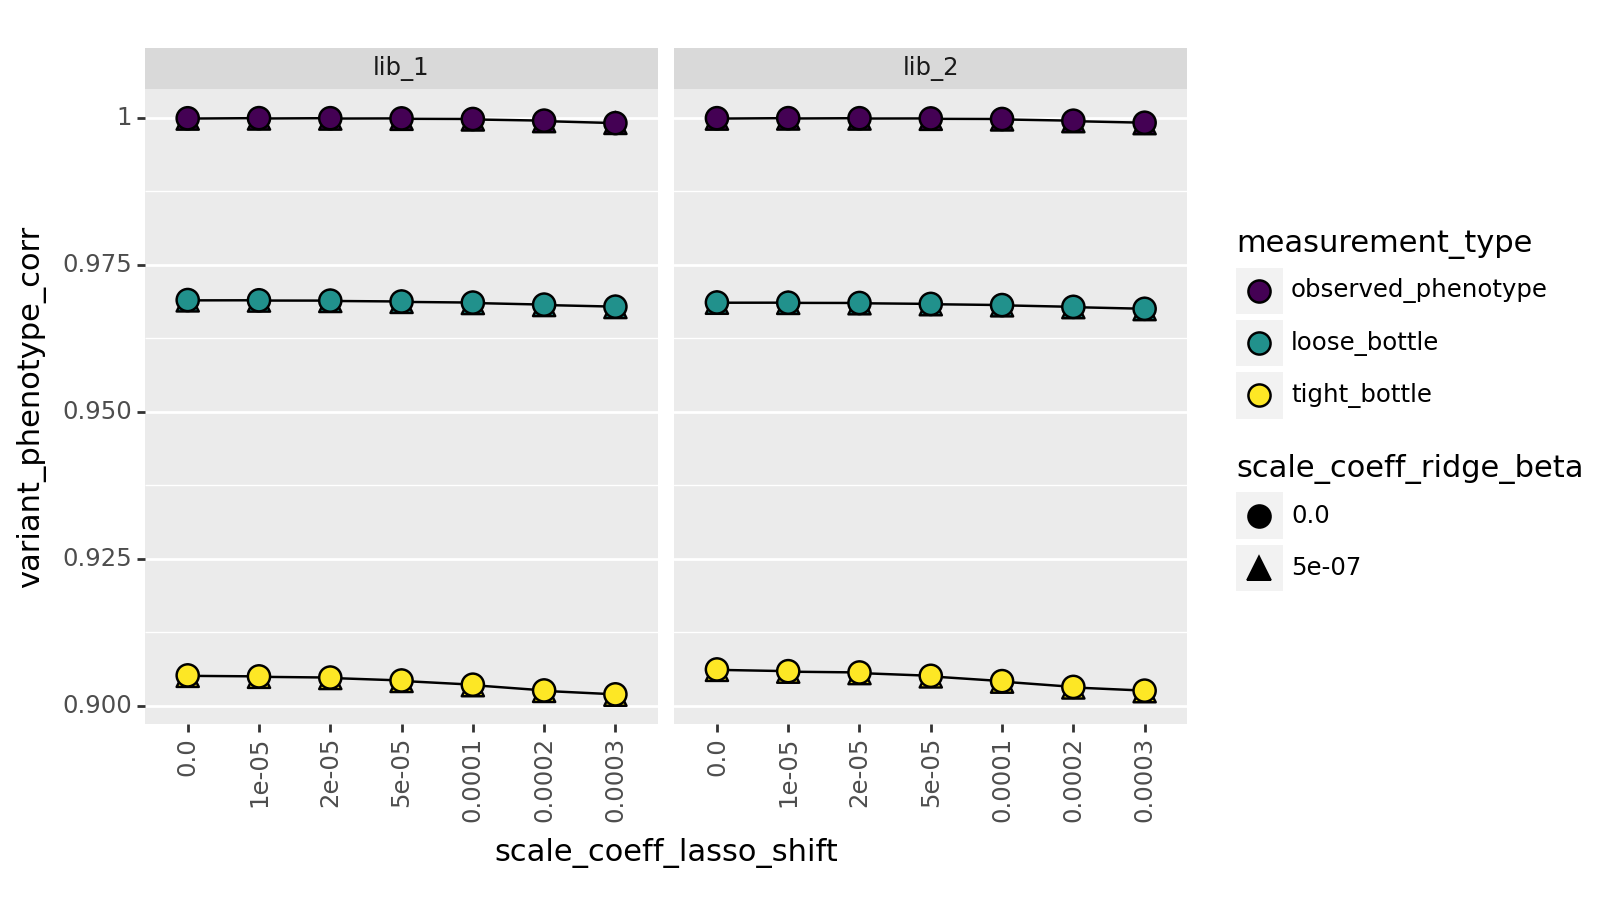

In [114]:
p = (
    ggplot(fit_collection)
    + geom_line(
        aes(
            x="scale_coeff_lasso_shift",
            y="variant_phenotype_corr",
            group="measurement_type",
        ),
        # size=1
    ) 
    + geom_point(
        aes(
            x="scale_coeff_lasso_shift",
            y="variant_phenotype_corr",
            fill="measurement_type",
            shape="scale_coeff_ridge_beta",
        ),
        size=4
    )
    # + scale_y_continuous(limits=[0.9, 1])
    + facet_grid("~library")
    + theme(
        figure_size=(4 * len(libs), 2.25 * len(bottlenecks)),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
)
_ = p.draw(show=True)

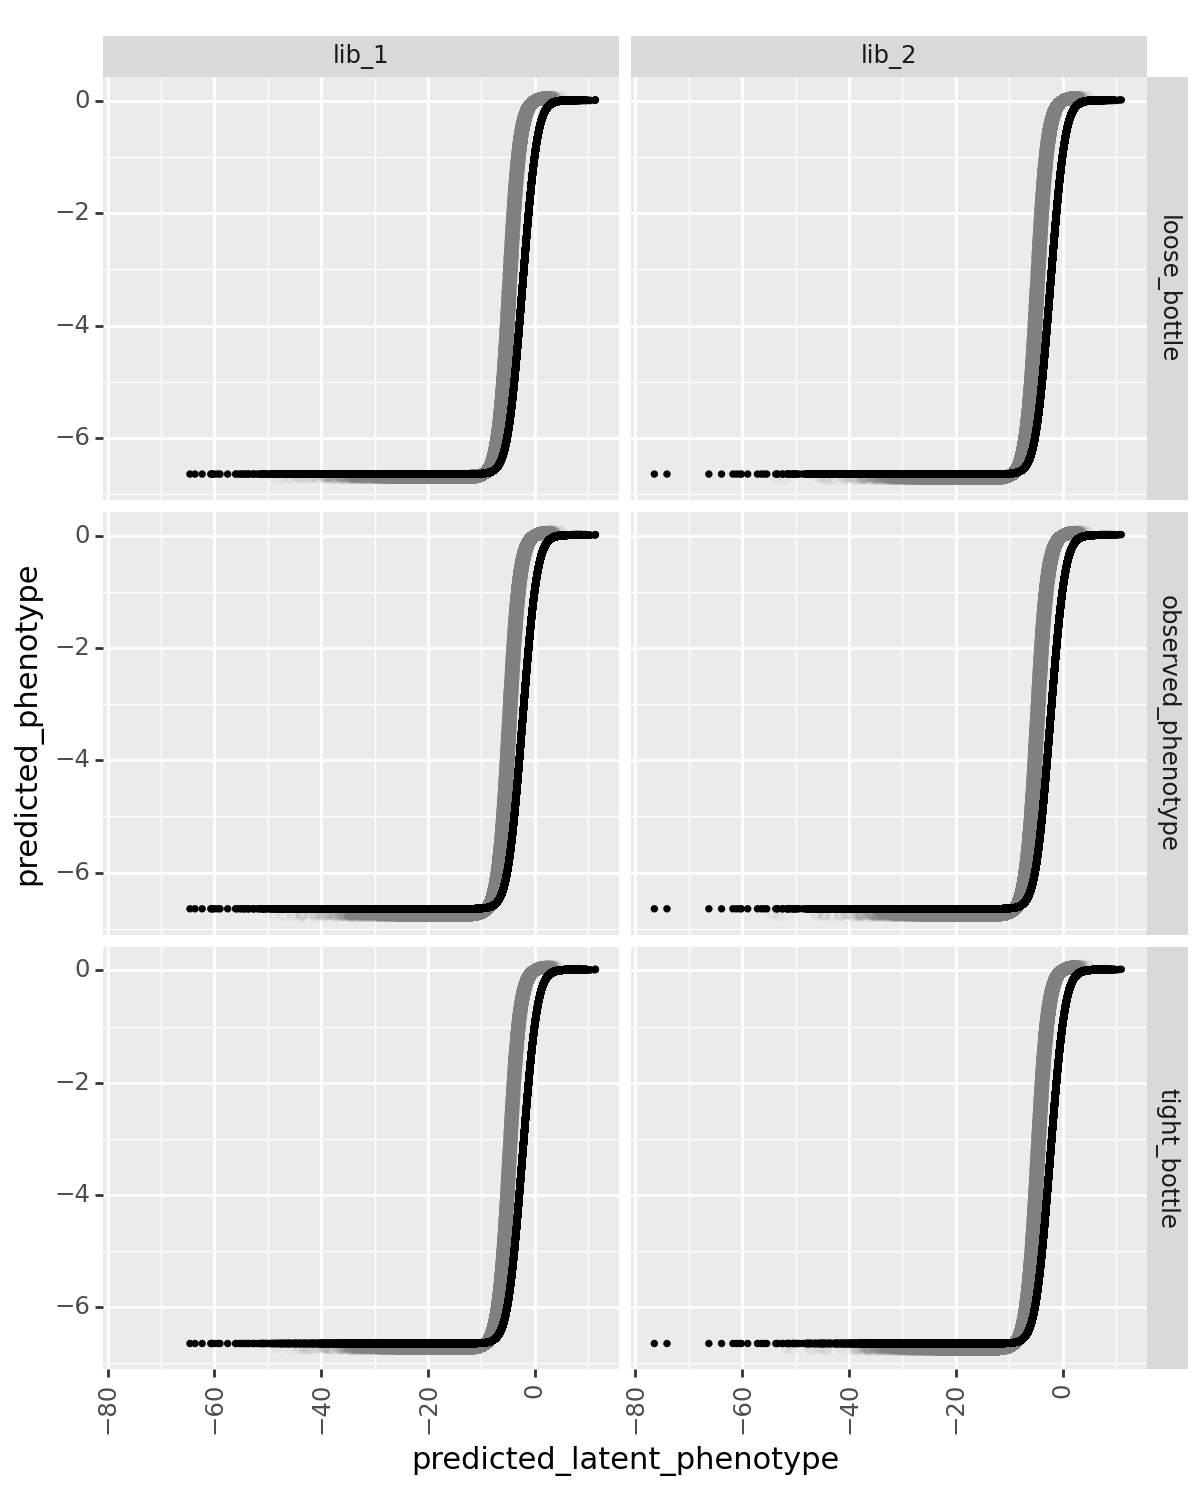

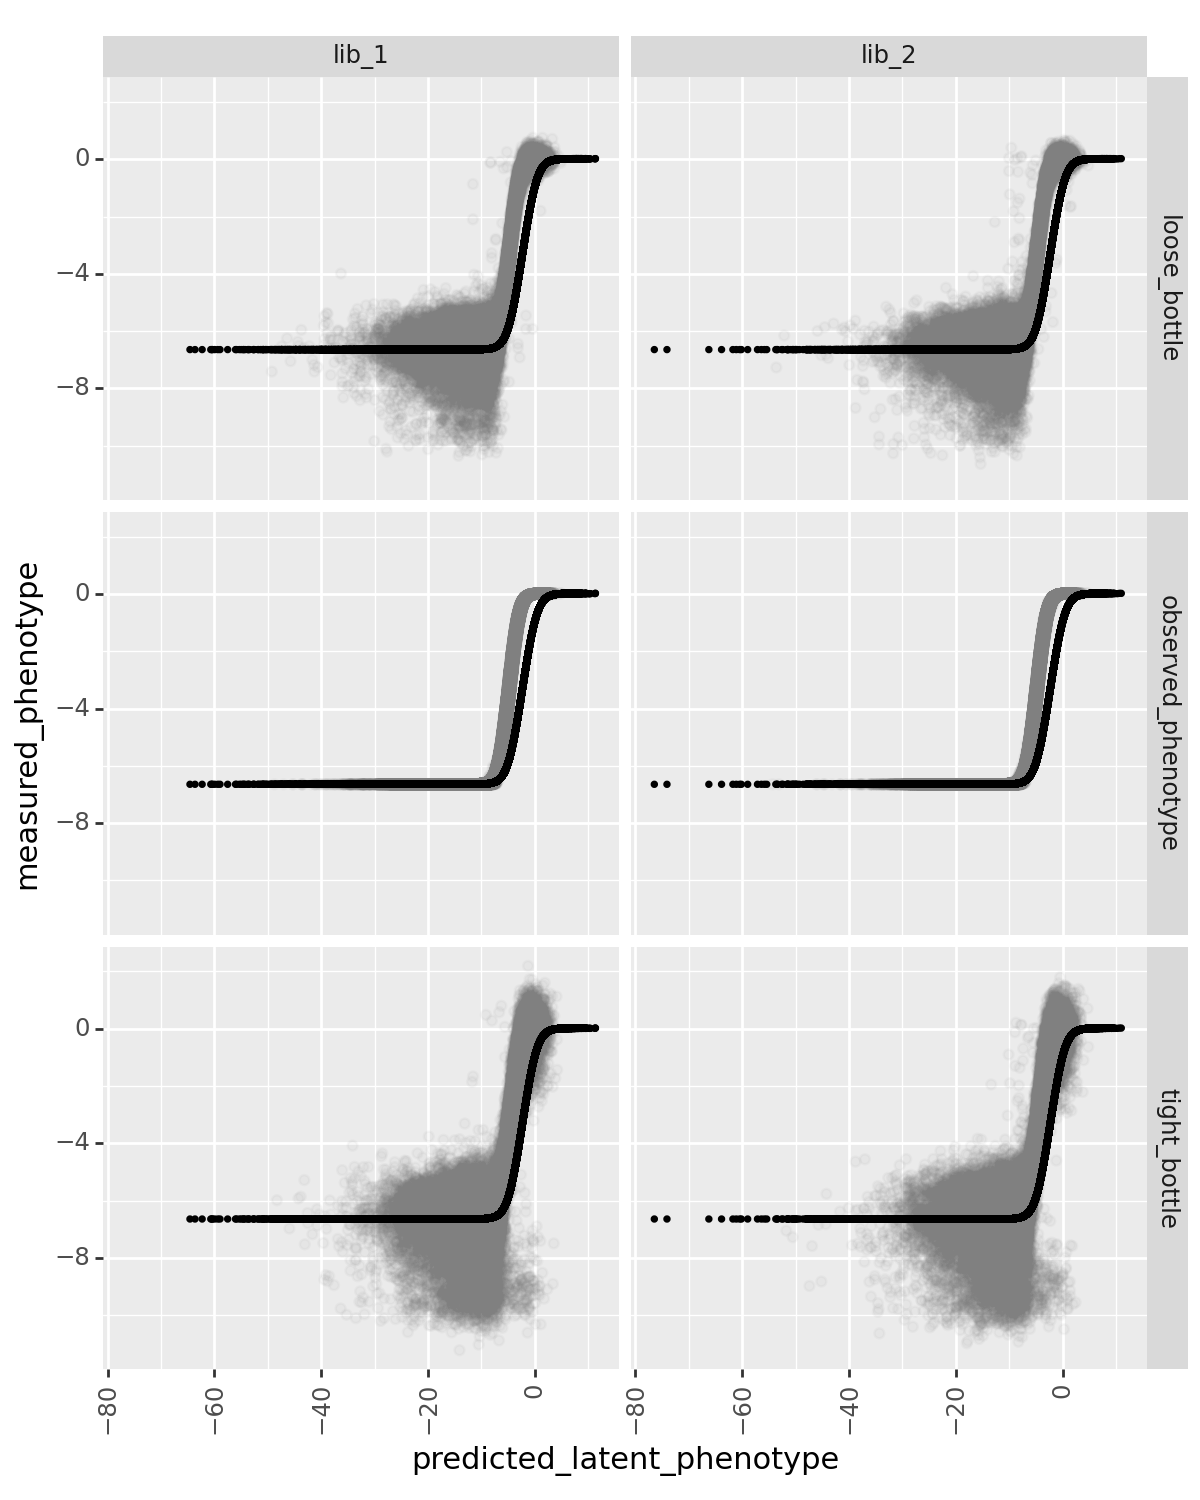

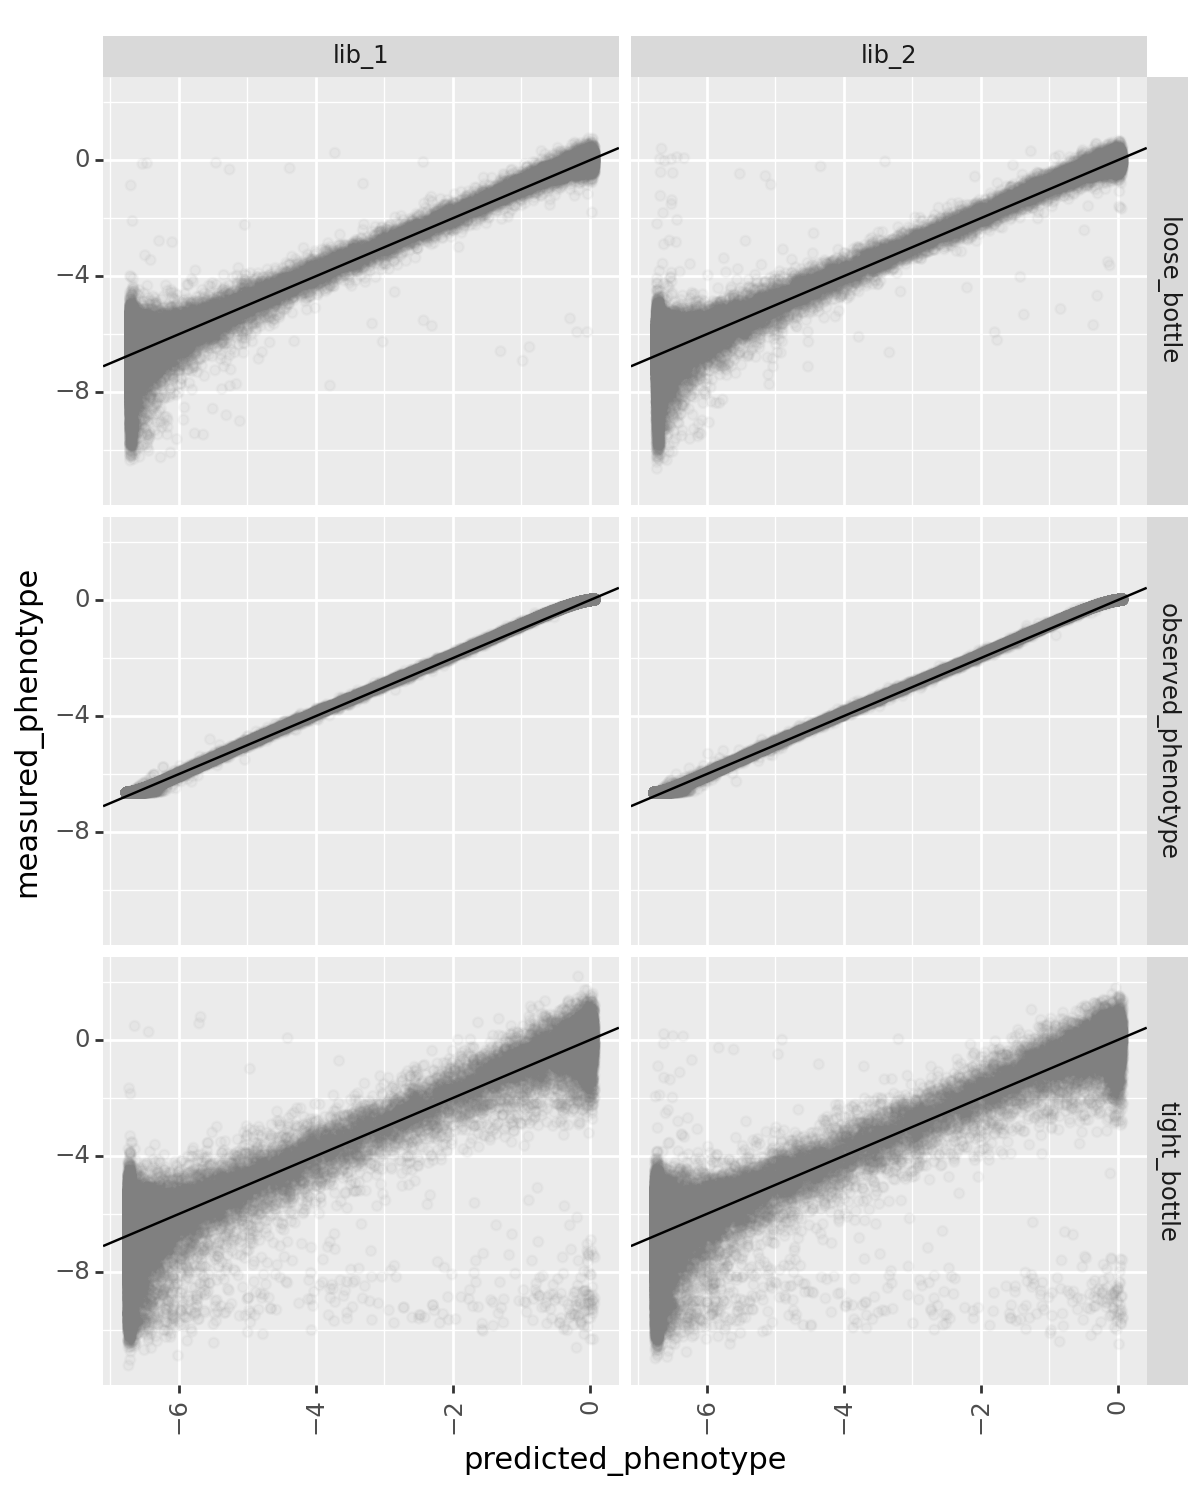

In [97]:
lasso = 5e-05
data = variants_df.query(f"lasso == {lasso}")
# for library, title in zip(["lib_1", "lib_2"], ["Library 1", "homolog 2"]):
for x, y in itertools.combinations(
    ["predicted_latent_phenotype", "predicted_phenotype", "measured_phenotype"], 2
):
    p = (
        ggplot(data.sample(frac=1.0))
        + geom_point(
            aes(
                # data=data,
                # fill="post_sample + library",
                x=x,
                y=y    
                # x="predicted_latent_phenotype",
                # y="predicted_phenotype"
            ),
            alpha=0.05,
            # size=0.5,
            color="grey"
        )
        # ground truth 
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(3 * len(libs), 2.5 * len(data["measurement_type"].unique())),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
        # + labs(title=title)
        # make point more alpha
        # + scale_alpha(0.01)
    )

    if x == "predicted_latent_phenotype":
        p+= geom_point(
            aes(
                # fill="post_sample + library",
                # x=x,
                # y=y    
                x="true_latent_phenotype",
                y="true_observed_phenotype"
            ),
            # alpha=0.05,
            size=0.5,
            # color="grey"
        )
    else:
        p += geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
            # size=0.5,
        )

    
        
    _ = p.draw(show=True)

Overall these look very similar to the simulated sigmoid. Note that both the homolog conditions share the same sigmoid, and there is no latent offset ($\alpha_d$) parameter in these models.

In [98]:
variants_df

condition     aa_substitutions  measured_phenotype  \
0            h1                 Q28P           -2.58E-01   
1            h1                 G50E            7.51E-02   
2            h1                 R48G           -2.66E+00   
3            h1        S3R G10Y L49H           -6.58E+00   
4            h1       F18T Q21E C44T           -6.19E+00   
...         ...                  ...                 ...   
30258        h2  V24P Q28L T36A G37A           -6.91E+00   
30259        h2            V19Y P30T           -6.71E+00   
30260        h2            V24S P30*           -5.06E+00   
30261        h2            V19L N46A           -9.10E-01   
30262        h2   P6R R20S T35S S47I           -6.31E+00   

                                             var_wrt_ref  \
0                                                   Q28P   
1                                                   G50E   
2                                                   R48G   
3                                          S3R G10Y L49H   
4                                         F18T Q21E C44T   
...                                                  ...   
30258  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30259  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30260  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30261  G6P G10C V11C V12S R13W S14W S25H Y38W T45G L4...   
30262  G6R G10C V11C V12S R13W S14W S25H Y38W T45G L4...   

       predicted_latent_phenotype  predicted_phenotype library  \
0                       -2.17E+00            -3.86E-01   lib_1   
1                       -9.65E-01            -8.49E-02   lib_1   
2                       -4.51E+00            -2.79E+00   lib_1   
3                       -1.17E+01            -6.67E+00   lib_1   
4                       -1.09E+01            -6.67E+00   lib_1   
...                           ...                  ...     ...   
30258                   -1.56E+01            -6.72E+00   lib_2   
30259                   -1.82E+00            -4.04E-01   lib_2   
30260                   -1.20E+01            -6.71E+00   lib_2   
30261                   -4.68E+00            -3.82E+00   lib_2   
30262                   -2.07E+01            -6.72E+00   lib_2   

      measurement_type    lasso  predicted_enrichment  measured_enrichment  \
0         loose_bottle 0.00E+00              7.65E-01             8.36E-01   
1         loose_bottle 0.00E+00              9.43E-01             1.05E+00   
2         loose_bottle 0.00E+00              1.45E-01             1.58E-01   
3         loose_bottle 0.00E+00              9.79E-03             1.05E-02   
4         loose_bottle 0.00E+00              9.84E-03             1.37E-02   
...                ...      ...                   ...                  ...   
30258     tight_bottle 3.00E-04              9.51E-03             8.30E-03   
30259     tight_bottle 3.00E-04              7.56E-01             9.52E-03   
30260     tight_bottle 3.00E-04              9.53E-03             3.00E-02   
30261     tight_bottle 3.00E-04              7.08E-02             5.32E-01   
30262     tight_bottle 3.00E-04              9.50E-03             1.26E-02   

       fit_idx  true_latent_phenotype  true_observed_phenotype  \
0            0               1.70E+00                -2.30E-01   
1            0               3.48E+00                -3.36E-02   
2            0              -1.72E+00                -2.63E+00   
3            0              -1.23E+01                -6.64E+00   
4            0              -1.08E+01                -6.64E+00   
...        ...                    ...                      ...   
30258       41              -1.92E+01                -6.64E+00   
30259       41               1.80E+00                -1.98E-01   
30260       41              -1.28E+01                -6.64E+00   
30261       41              -2.46E+00                -3.49E+00   
30262       41              -2.58E+01                -6.64E+00   

       true_enrichment  
0             8.

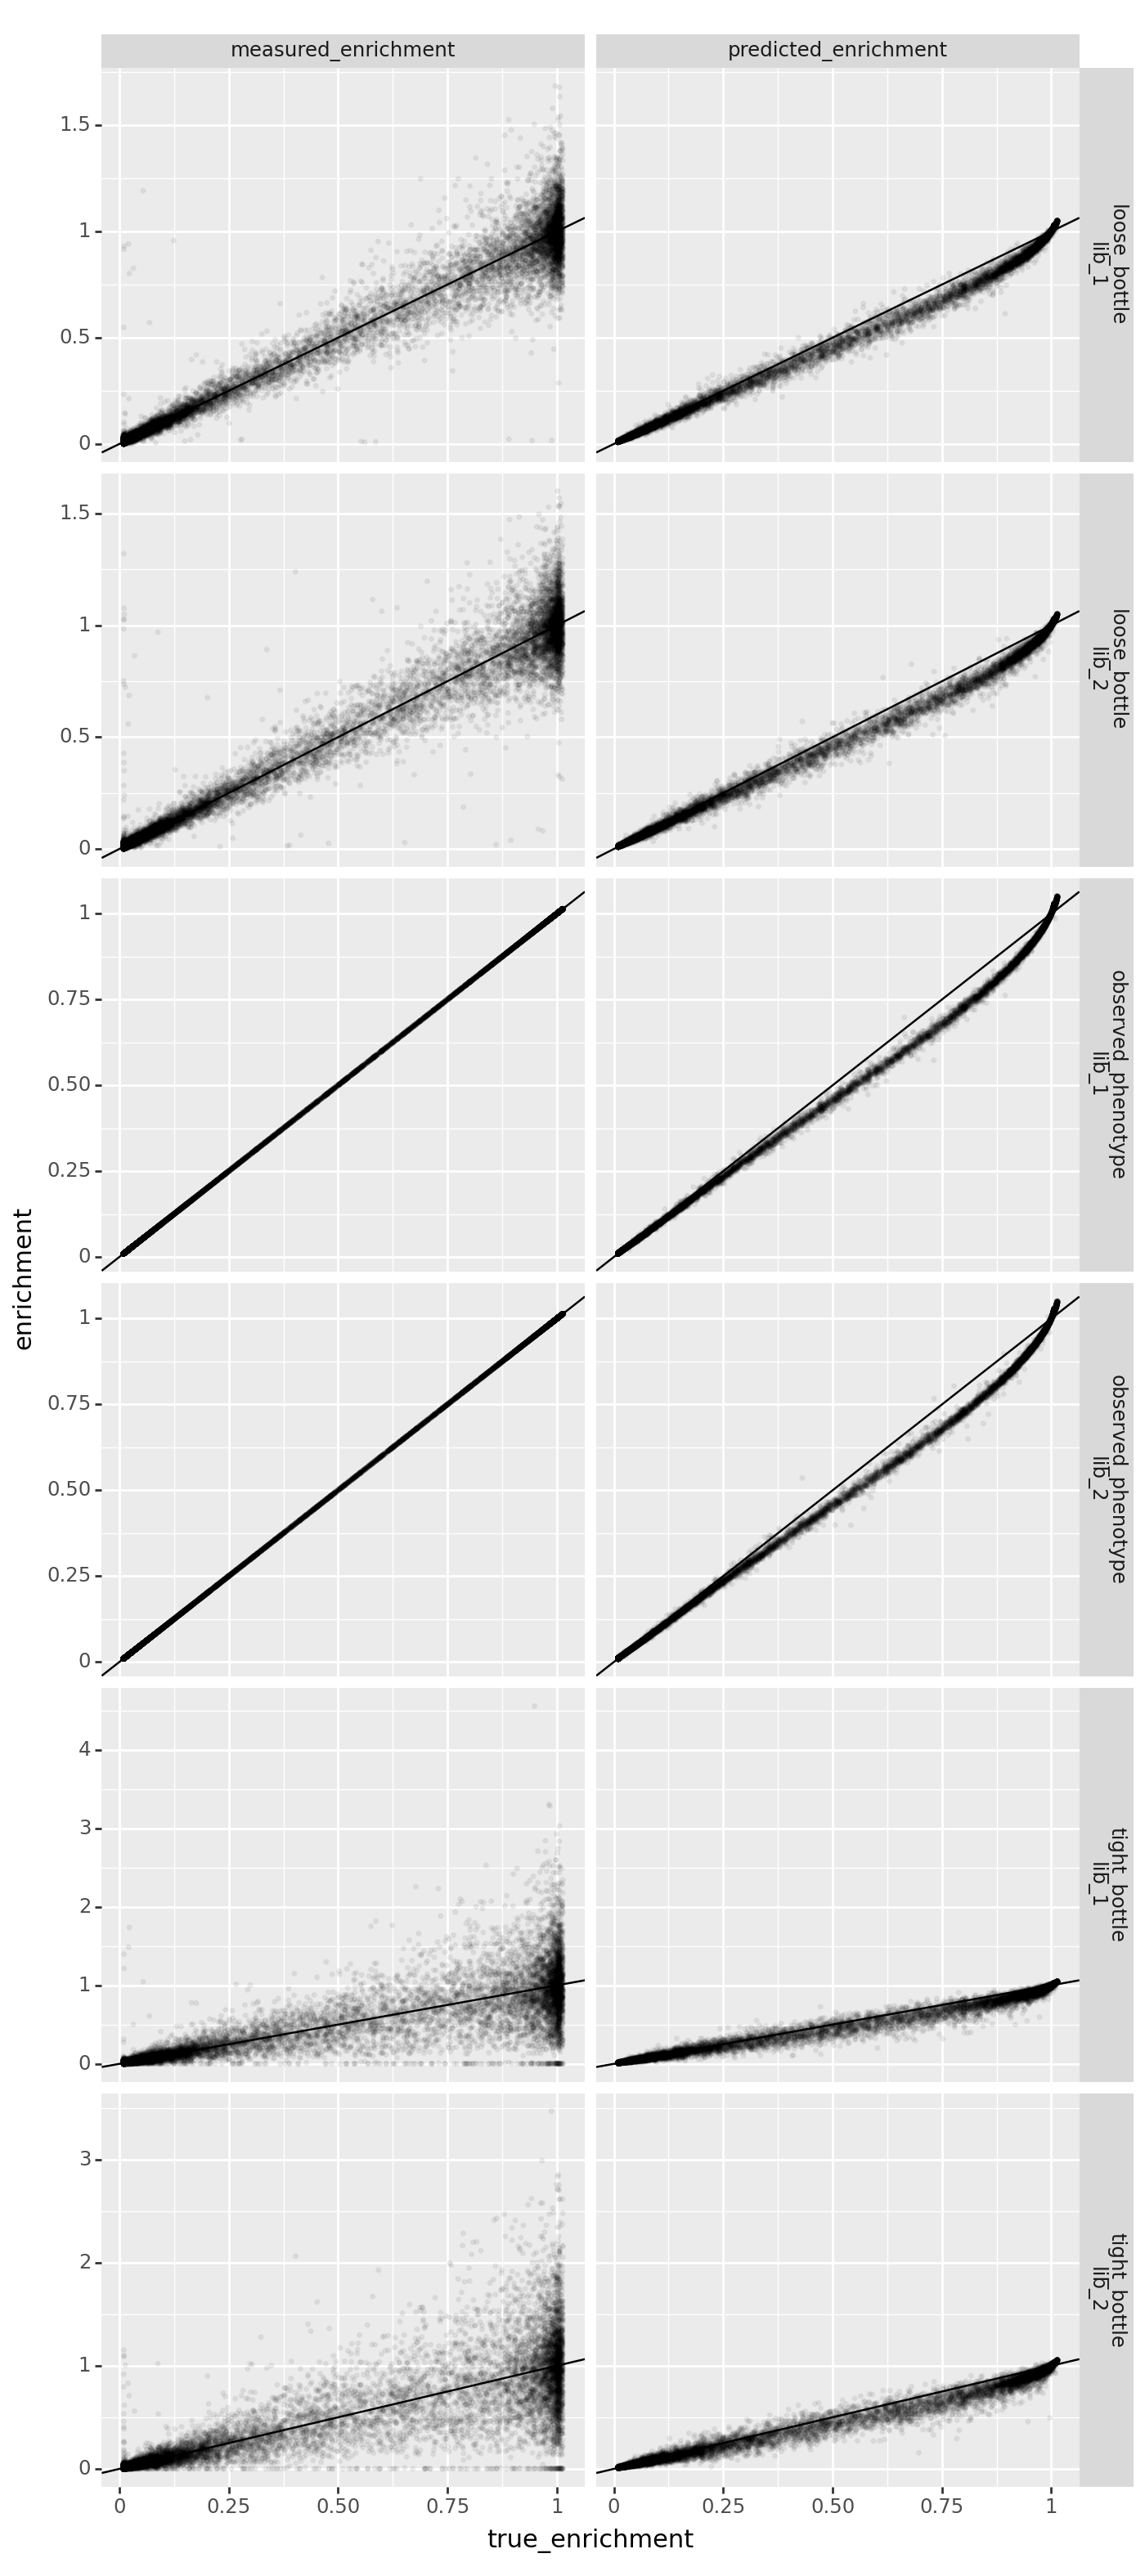

In [99]:
p = (
    ggplot(
        data.melt(
            # id_vars=["measurement_type", "library", "condition", "true_enrichment"],
            id_vars=["measurement_type", "library", "true_enrichment"],
            value_vars=["predicted_enrichment", "measured_enrichment"],
            var_name="enrichment_type",
            value_name="enrichment",
        ),
        # variants_df,
        aes("true_enrichment", "enrichment"),
    )
    + geom_abline(
        slope=1,
        intercept=0, 
        # alpha=0.5,
        # size=0.5,
    )
    + geom_point(alpha=0.05, size=0.5)
    # + facet_grid("measurement_type + library + condition ~ enrichment_type", scales="free_y")
    + facet_grid("measurement_type + library ~ enrichment_type", scales="free_y")
    + theme(
        figure_size=(
            7,
            2.75 * (variants_df["measurement_type"].nunique() + variants_df["library"].nunique()) + variants_df["condition"].nunique(),
        )
    )
)

_ = p.draw(show=True)

## Evaulate beta and shift parameter recovery

Next, let's take a look at the inferred shift parameters for each of the libraries.

In [100]:
mut_effects_df.head()

mutation   beta_h1 wt_aa  site mut_aa  shifted_site    shift   beta_h2  \
0      G1A -5.81E+00     G     1      A         False 0.00E+00 -5.81E+00   
1      G1C -8.88E+00     G     1      C         False 0.00E+00 -8.88E+00   
2      G1D -1.01E+00     G     1      D         False 0.00E+00 -1.01E+00   
3      G1E -8.35E+00     G     1      E         False 0.00E+00 -8.35E+00   
4      G1F -1.35E+00     G     1      F         False 0.00E+00 -1.35E+00   

  aaseq_h1 aaseq_h2  
0        G        G  
1        G        G  
2        G        G  
3        G        G  
4        G        G

In [101]:
fit_collection.head()

model                   dataset_name  \
0  Model(Model-0)  lib_1_loose_bottle_func_score   
1  Model(Model-0)  lib_1_loose_bottle_func_score   
2  Model(Model-0)  lib_1_loose_bottle_func_score   
3  Model(Model-0)  lib_1_loose_bottle_func_score   
4  Model(Model-0)  lib_1_loose_bottle_func_score   

                                  step_loss epistatic_model output_activation  \
0  [8.948822093580924, 0.34329994451951584]         Sigmoid          Identity   
1   [8.948822093580924, 0.3433553824198374]         Sigmoid          Identity   
2   [8.948822093580924, 0.3440688227249587]         Sigmoid          Identity   
3   [8.948822093580924, 0.3460425485722288]         Sigmoid          Identity   
4   [8.948822093580924, 0.3482627681973888]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                0.00E+00               1.00E-06                       0   
1                1.00E-05               1.00E-06                       0   
2                2.00E-05               1.00E-06                       0   
3                5.00E-05               1.00E-06                       0   
4                1.00E-04               1.00E-06                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ... iterations_per_step  \
0                       0                         0  ...               10000   
1                       0                         0  ...               10000   
2                       0                         0  ...               10000   
3                       0                         0  ...               10000   
4                       0                         0  ...               10000   

  n_hidden_units lower_bound PRNGKey infer_beta_naught measurement_type  \
0              5        None       0          4.83E+00     loose_bottle   
1              5        None       0          4.98E+00     loose_bottle   
2              5        None       0          5.00E+00     loose_bottle   
3              5        None       0          4.99E+00     loose_bottle   
4              5        None       0          4.97E+00     loose_bottle   

  library variant_phenotype_corr beta_corr shift_corr  
0   lib_1               9.69E-01  9.88E-01   3.50E-01  
1   lib_1               9.69E-01  9.89E-01   7.67E-01  
2   lib_1               9.69E-01  9.90E-01   8.37E-01  
3   lib_1               9.69E-01  9.91E-01   8.91E-01  
4   lib_1               9.68E-01  9.90E-01   8.83E-01  

[5 rows x 27 columns]

In [115]:
mutations_df = pd.concat(
    [
        row.model.get_mutations_df()
        .assign(
            library=row.library,
            measurement_type=row.measurement_type,
            lasso=row.scale_coeff_lasso_shift,
            fit_idx = idx,
            ridge=row.scale_coeff_ridge_beta
        )
        .rename(
            {
                'beta' : 'predicted_beta',
                'shift_h2' : 'predicted_shift_h2',
            }, 
            axis=1
        )    
        .merge(
            mut_effects_df.rename(
                {
                    'beta_h1' : 'true_beta',
                    'beta_h2' : 'true_beta_h2',
                    'shift' : 'true_shift',
                },
                axis=1
            ),
            on='mutation'
        )
        for idx, row in fit_collection.iterrows()
    ]
)
mutations_df.head()

mutation  predicted_beta  predicted_shift_h2  predicted_func_score_h1  \
0      G1A       -4.42E+00            8.36E-02                -1.63E+00   
1      G1C       -6.72E+00           -1.01E+00                -5.08E+00   
2      G1D       -1.02E+00            1.80E-01                -4.62E-02   
3      G1E       -6.64E+00            2.68E-01                -4.98E+00   
4      G1F       -1.03E+00            3.88E-02                -4.75E-02   

   predicted_func_score_h2  times_seen_h1  times_seen_h2 wts  sites muts  ...  \
0                -1.52E+00             47             47   G      1    A  ...   
1                -5.94E+00             30             30   G      1    C  ...   
2                -1.82E-02             20             20   G      1    D  ...   
3                -4.61E+00             37             37   G      1    E  ...   
4                -2.86E-02             25             25   G      1    F  ...   

     ridge true_beta  wt_aa  site  mut_aa  shifted_site true_shift  \
0 0.00E+00 -5.81E+00      G     1       A         False   0.00E+00   
1 0.00E+00 -8.88E+00      G     1       C         False   0.00E+00   
2 0.00E+00 -1.01E+00      G     1       D         False   0.00E+00   
3 0.00E+00 -8.35E+00      G     1       E         False   0.00E+00   
4 0.00E+00 -1.35E+00      G     1       F         False   0.00E+00   

   true_beta_h2 aaseq_h1  aaseq_h2  
0     -5.81E+00        G         G  
1     -8.88E+00        G         G  
2     -1.01E+00        G         G  
3     -8.35E+00        G         G  
4     -1.35E+00        G         G  

[5 rows x 24 columns]

In [116]:
# add correlation of predicted and true beta, and predicted and true shift to the fit collection  in own column
fit_collection["beta_corr"] = np.nan
fit_collection["shift_corr"] = np.nan
for idx, model_mutations_df in mutations_df.groupby(["fit_idx"]):
    fit_collection.loc[idx, "beta_corr"] = model_mutations_df["predicted_beta"].corr(model_mutations_df["true_beta"])
    fit_collection.loc[idx, "shift_corr"] = model_mutations_df["predicted_shift_h2"].corr(model_mutations_df["true_shift"])

In [155]:
data = (
    fit_collection
    # .query("scale_coeff_ridge_beta == 5e-07")
    .query("scale_coeff_ridge_beta == 0.0")
    .assign(
        measurement_library = lambda x: x["measurement_type"].astype(str) + " " + x["library"]
    )
    .melt(
        id_vars=["scale_coeff_lasso_shift", "library", "measurement_type", "measurement_library"],
        value_vars=["beta_corr", "shift_corr", "variant_phenotype_corr"],
        var_name="parameter",
        value_name="correlation",
    )
)

In [156]:
data

scale_coeff_lasso_shift library measurement_type measurement_library  \
0                  0.00E+00   lib_1     loose_bottle  loose_bottle lib_1   
1                  1.00E-05   lib_1     loose_bottle  loose_bottle lib_1   
2                  2.00E-05   lib_1     loose_bottle  loose_bottle lib_1   
3                  5.00E-05   lib_1     loose_bottle  loose_bottle lib_1   
4                  1.00E-04   lib_1     loose_bottle  loose_bottle lib_1   
..                      ...     ...              ...                 ...   
121                2.00E-05   lib_2     tight_bottle  tight_bottle lib_2   
122                5.00E-05   lib_2     tight_bottle  tight_bottle lib_2   
123                1.00E-04   lib_2     tight_bottle  tight_bottle lib_2   
124                2.00E-04   lib_2     tight_bottle  tight_bottle lib_2   
125                3.00E-04   lib_2     tight_bottle  tight_bottle lib_2   

                  parameter  correlation  
0                 beta_corr     9.80E-01  
1                 beta_corr     9.82E-01  
2                 beta_corr     9.82E-01  
3                 beta_corr     9.83E-01  
4                 beta_corr     9.82E-01  
..                      ...          ...  
121  variant_phenotype_corr     9.06E-01  
122  variant_phenotype_corr     9.05E-01  
123  variant_phenotype_corr     9.04E-01  
124  variant_phenotype_corr     9.03E-01  
125  variant_phenotype_corr     9.03E-01  

[126 rows x 6 columns]

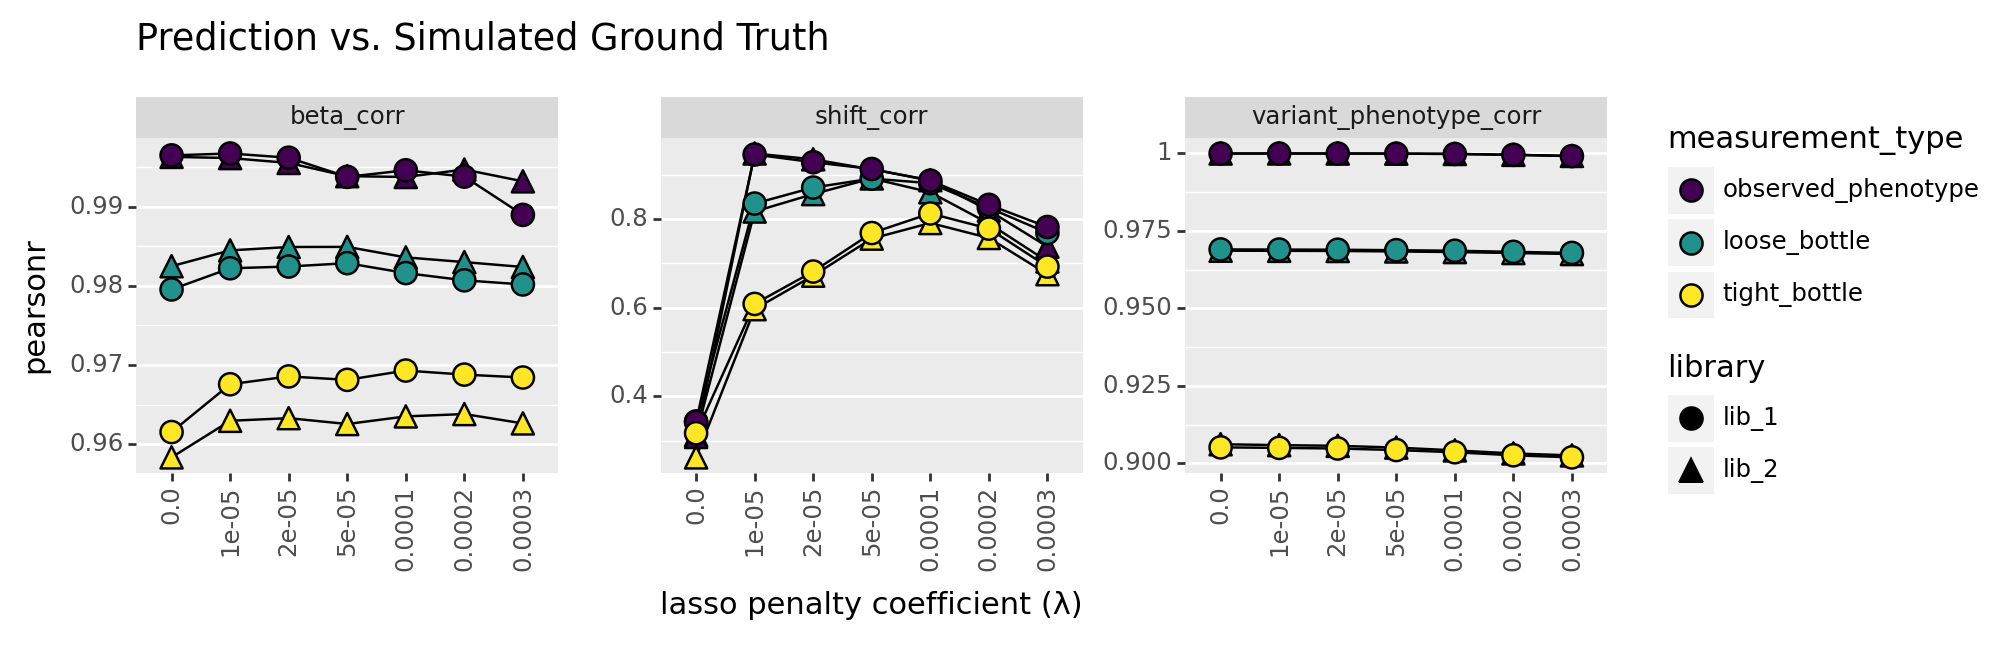

In [157]:
p = (
    ggplot(data)
    + geom_line(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"correlation",
            group="measurement_library",
        ),
    )
    + geom_point(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"correlation",
            fill="measurement_type",
            shape="library"
        ),
        size=4
    )
    # + scale_y_continuous(limits=[0.9, 1])
    + facet_wrap("parameter", scales="free_y")
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        title=f"Prediction vs. Simulated Ground Truth",
        x="lasso penalty coefficient (λ)",
        y="pearsonr"
    )
)
_ = p.draw(show=True)

Next, we would like to know how the libraries correlate.

In [160]:
charts = {}
for measurement_type, fits in fit_collection.groupby("measurement_type"):
    mc = multidms.model_collection.ModelCollection(fits)
    charts[measurement_type] = mc.mut_param_dataset_correlation()


cache miss - this could take a moment
cache miss - this could take a moment
cache miss - this could take a moment


In [162]:
charts["loose_bottle"]

alt.FacetChart(...)

In [163]:
charts["tight_bottle"]

alt.FacetChart(...)

In [164]:
charts["observed_phenotype"]

alt.FacetChart(...)

## Cross validation

We would like to know if cross validation can help us select the best model. We can do this by breaking the variant data into a training and test set, and then fitting the model to the training set and evaluating the model on the test set. 

We'll start by splitting the prepped functional scores into a training and test set.

## individual model correlation

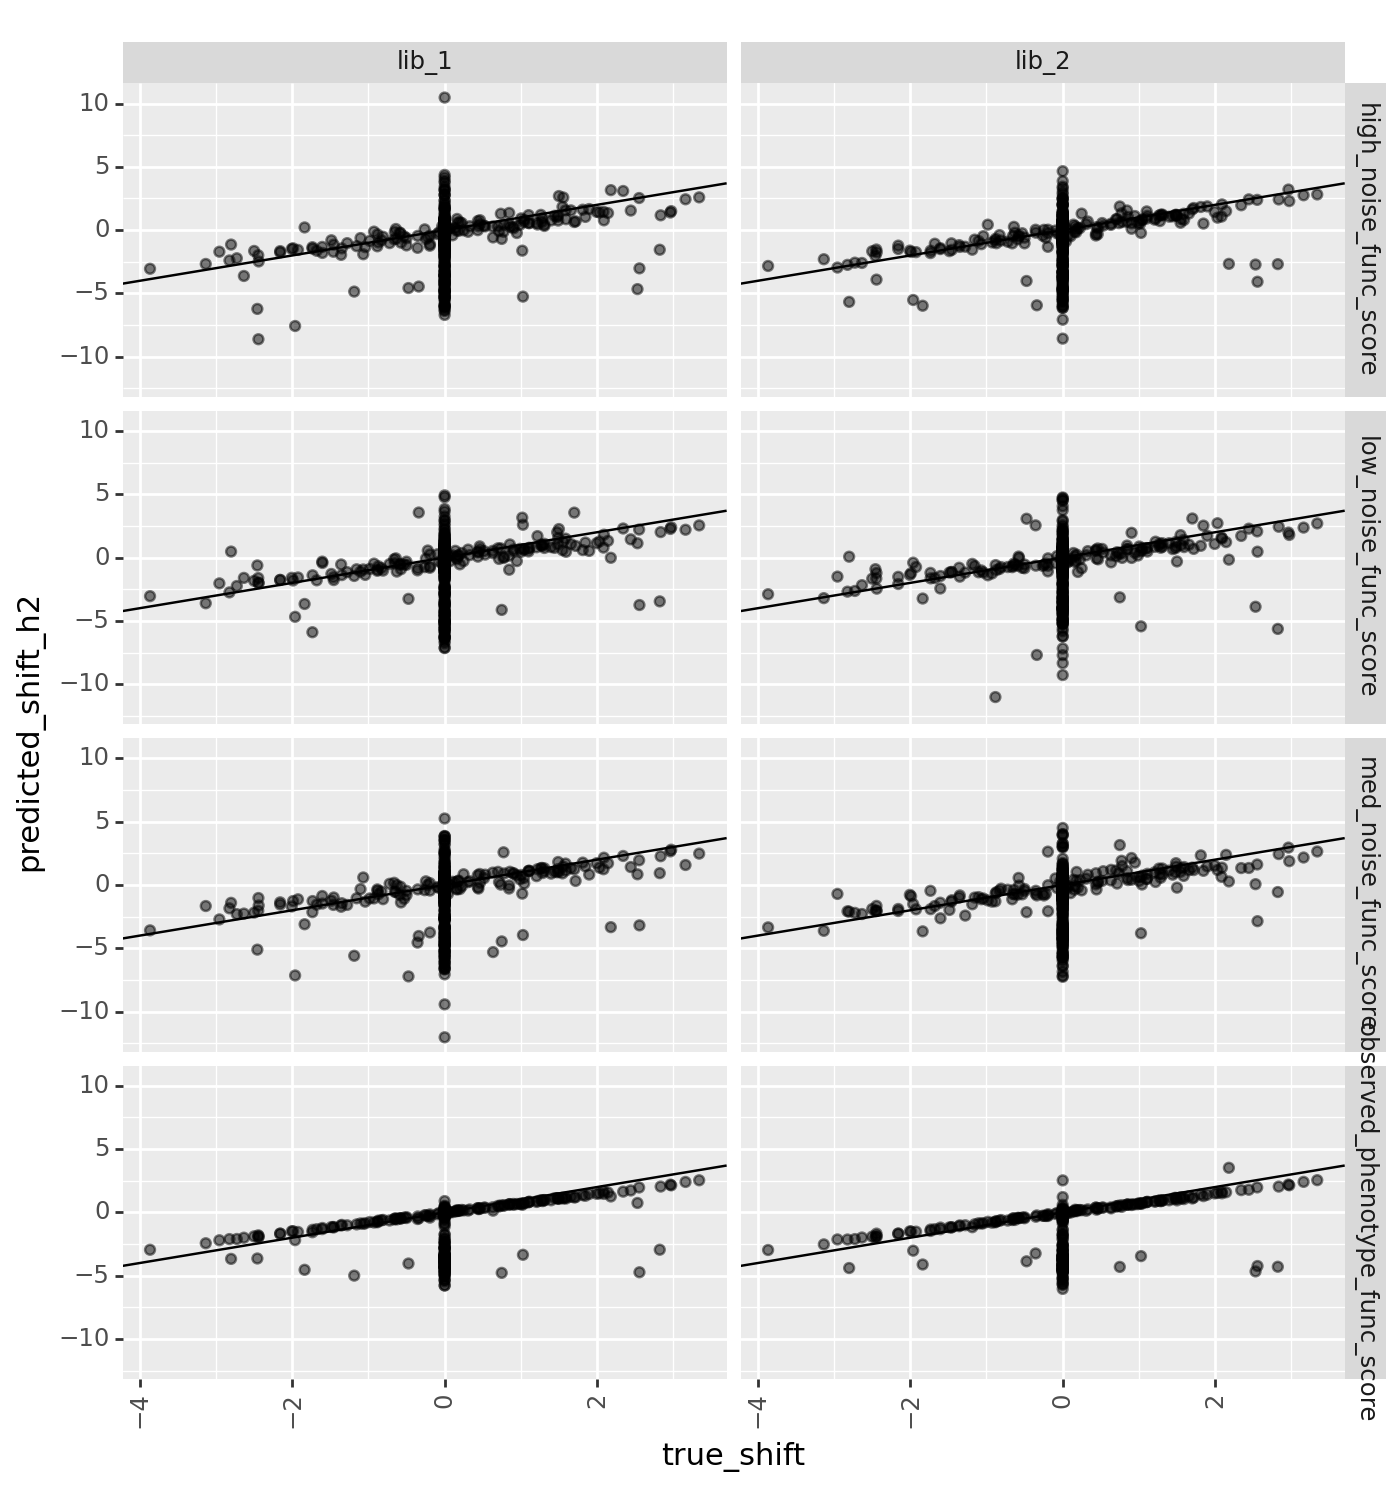

In [ ]:
# plot correlations of true and predicted shifts
for (x, y) in itertools.combinations(
    ["true_shift", "predicted_shift_h2"], 2
):
    p = (
        # ggplot(mutations_df.query("lasso == 1e-05"))
        ggplot(mutations_df.query("lasso == 0"))
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
            # size=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
            # size=0.5,
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(7 , 7.5),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
    )
    _ = p.draw(show=True)

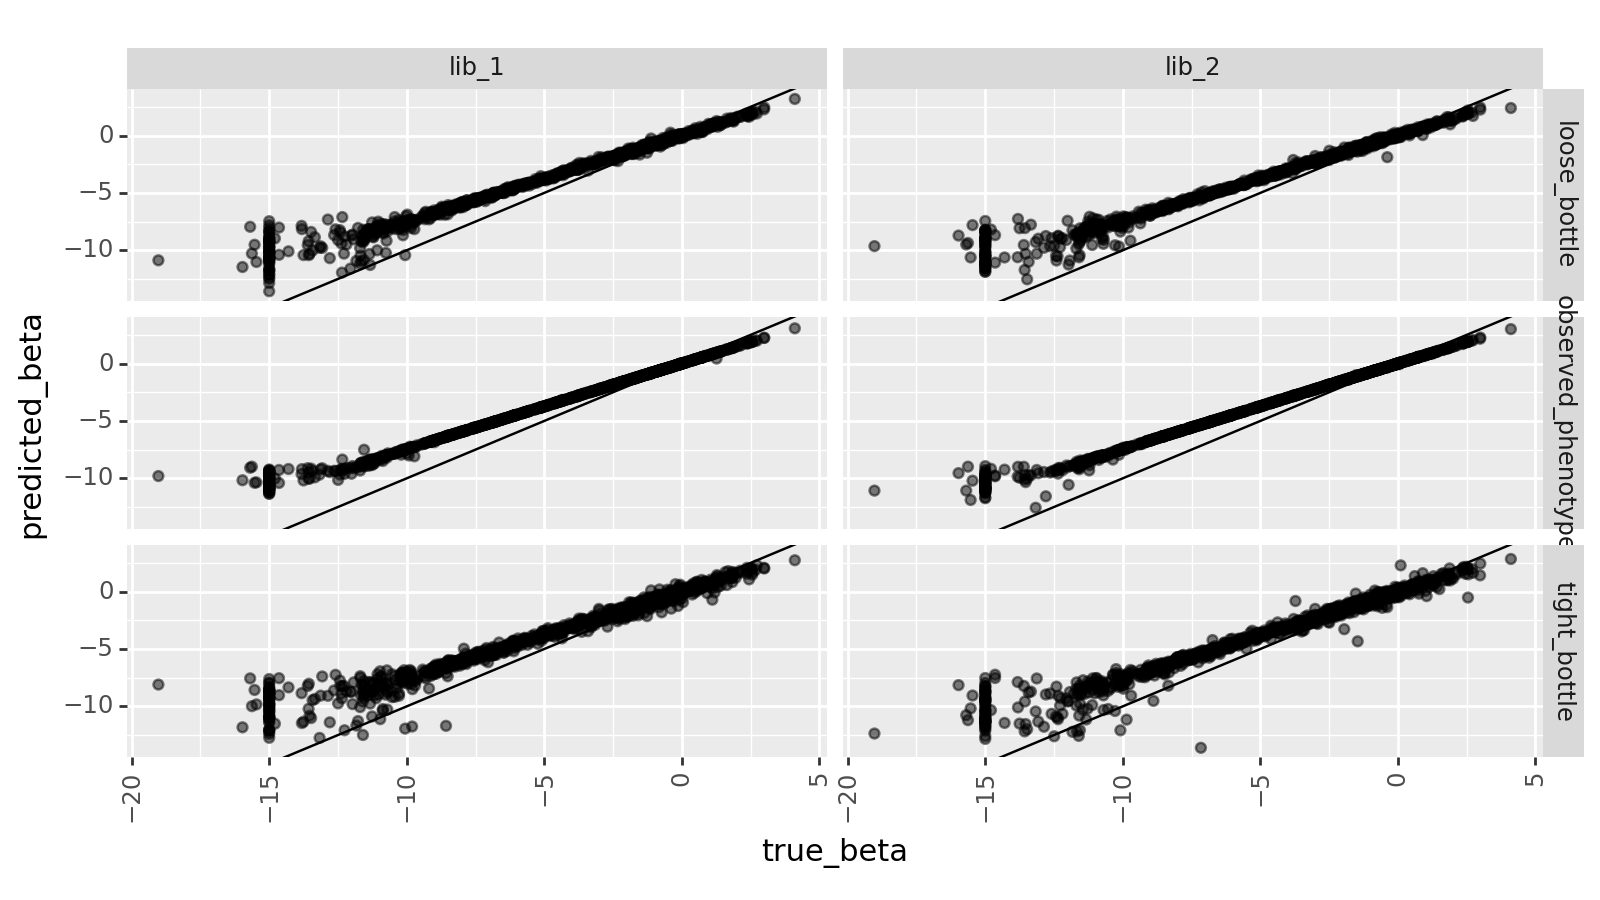

In [ ]:
 # plot correlations of true and predicted shifts
for (x, y) in itertools.combinations(
    ["true_beta", "predicted_beta"], 2
):
    p = (
        ggplot(mutations_df)
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
            # size=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("post_sample ~ library")
        + theme(
            figure_size=(4 * len(libs), 2.25 * len(bottlenecks)),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
    )
    _ = p.draw(show=True)

In [76]:
fit_collection.query("dataset_name.str.contains('low')")

model                dataset_name             step_loss  \
7   Model(Model-0)  lib_1_low_noise_func_score  [0.8304332321277331]   
8   Model(Model-0)  lib_1_low_noise_func_score  [0.8311752241577816]   
9   Model(Model-0)  lib_1_low_noise_func_score  [0.8323811068630753]   
10  Model(Model-0)  lib_1_low_noise_func_score   [0.836176107232124]   
11  Model(Model-0)  lib_1_low_noise_func_score  [0.8414905441642995]   
12  Model(Model-0)  lib_1_low_noise_func_score  [0.8498003094661483]   
13  Model(Model-0)  lib_1_low_noise_func_score  [0.8560132976893647]   
35  Model(Model-1)  lib_2_low_noise_func_score  [0.8253092996545252]   
36  Model(Model-1)  lib_2_low_noise_func_score  [0.8261174191519487]   
37  Model(Model-1)  lib_2_low_noise_func_score  [0.8273289700450076]   
38  Model(Model-1)  lib_2_low_noise_func_score  [0.8312029647246718]   
39  Model(Model-1)  lib_2_low_noise_func_score  [0.8370867829429016]   
40  Model(Model-1)  lib_2_low_noise_func_score   [0.844849384561824]   
41  Model(Model-1)  lib_2_low_noise_func_score  [0.8501550716852035]   

   epistatic_model output_activation scale_coeff_lasso_shift  \
7          Sigmoid          Identity                     0.0   
8          Sigmoid          Identity                 0.00001   
9          Sigmoid          Identity                 0.00002   
10         Sigmoid          Identity                 0.00005   
11         Sigmoid          Identity                  0.0001   
12         Sigmoid          Identity                  0.0002   
13         Sigmoid          Identity                  0.0003   
35         Sigmoid          Identity                     0.0   
36         Sigmoid          Identity                 0.00001   
37         Sigmoid          Identity                 0.00002   
38         Sigmoid          Identity                 0.00005   
39         Sigmoid          Identity                  0.0001   
40         Sigmoid          Identity                  0.0002   
41         Sigmoid          Identity                  0.0003   

   scale_coeff_ridge_beta scale_coeff_ridge_shift scale_coeff_ridge_gamma  \
7                     0.0                       0                       0   
8                     0.0                       0                       0   
9                     0.0                       0                       0   
10                    0.0                       0                       0   
11                    0.0                       0                       0   
12                    0.0                       0                       0   
13                    0.0                       0                       0   
35                    0.0                       0                       0   
36                    0.0                       0                       0   
37                    0.0                       0                       0   
38                    0.0                       0                       0   
39                    0.0                       0                       0   
40                    0.0                       0                       0   
41                    0.0                       0                       0   

   scale_coeff_ridge_alpha_d  ... num_training_steps iterations_per_step  \
7                          0  ...                  1               10000   
8                          0  ...                  1               10000   
9                          0  ...                  1               10000   
10                         0  ...                  1               10000   
11                         0  ...                  1               10000   
12                         0  ...                  1               10000   
13                         0  ...                  1               10000   
35                         0  ...                  1               10000   
36                         0  ...                  1               10000   
37                         0  ...                  1   

cache miss - this could take a moment


cache miss - this could take a moment
cache miss - this could take a moment
cache miss - this could take a moment


In [93]:
charts[2]

alt.FacetChart(...)

In [91]:
charts[3]

alt.FacetChart(...)

## OLD CODE

Just a place for code to potentially use later

In [ ]:

model_params = {
    "dataset": data_objects["lib_1"], # only one replicate dataset
    "num_training_steps" : 10,
    "iterations_per_step": 1000, # Small number of iterations for purposes of this example
    "scale_coeff_lasso_shift": 1e-5,
}

fit_model = multidms.model_collection.fit_one_model(**model_params)

The fit model returns the following series. Note that the index 'model' contains a reference to the actual `multidms.Model` object.

In [ ]:
fit_model

model                                                           Model(Model-0)
dataset_name                                                             lib_1
step_loss                    [0.03800628658479281, 0.011929736216532595, 0....
epistatic_model                                                        Sigmoid
output_activation                                                     Identity
scale_coeff_lasso_shift                                                0.00001
scale_coeff_ridge_beta                                                       0
scale_coeff_ridge_shift                                                      0
scale_coeff_ridge_gamma                                                      0
scale_coeff_ridge_alpha_d                                                    0
huber_scale_huber                                                            1
gamma_corrected                                                          False
alpha_d                                             

<Axes: >

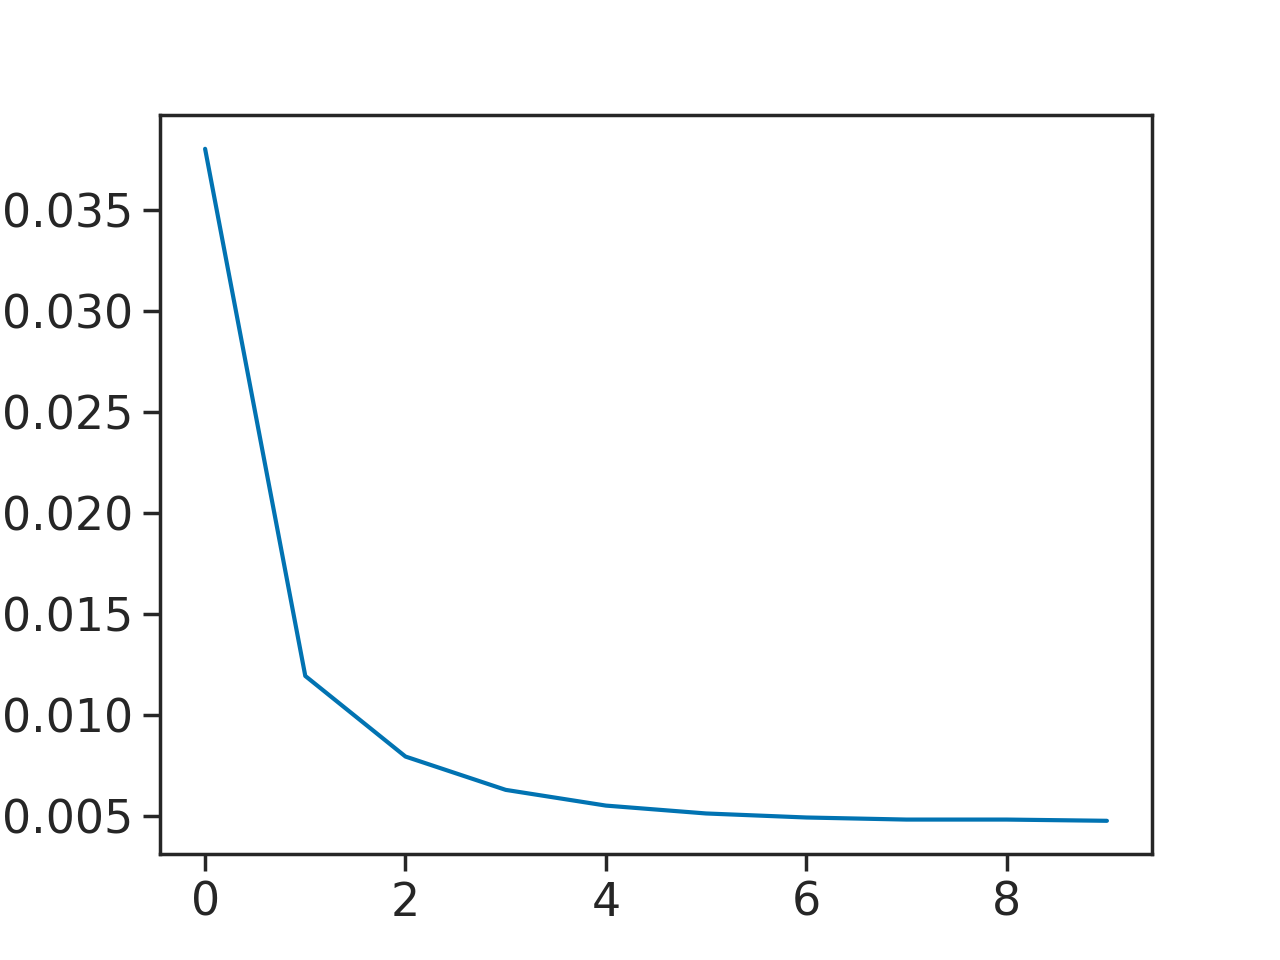

In [ ]:
sns.lineplot(fit_model.step_loss)

In [ ]:
fit_model.model.mut_param_heatmap(mut_param="shift")

alt.VConcatChart(...)

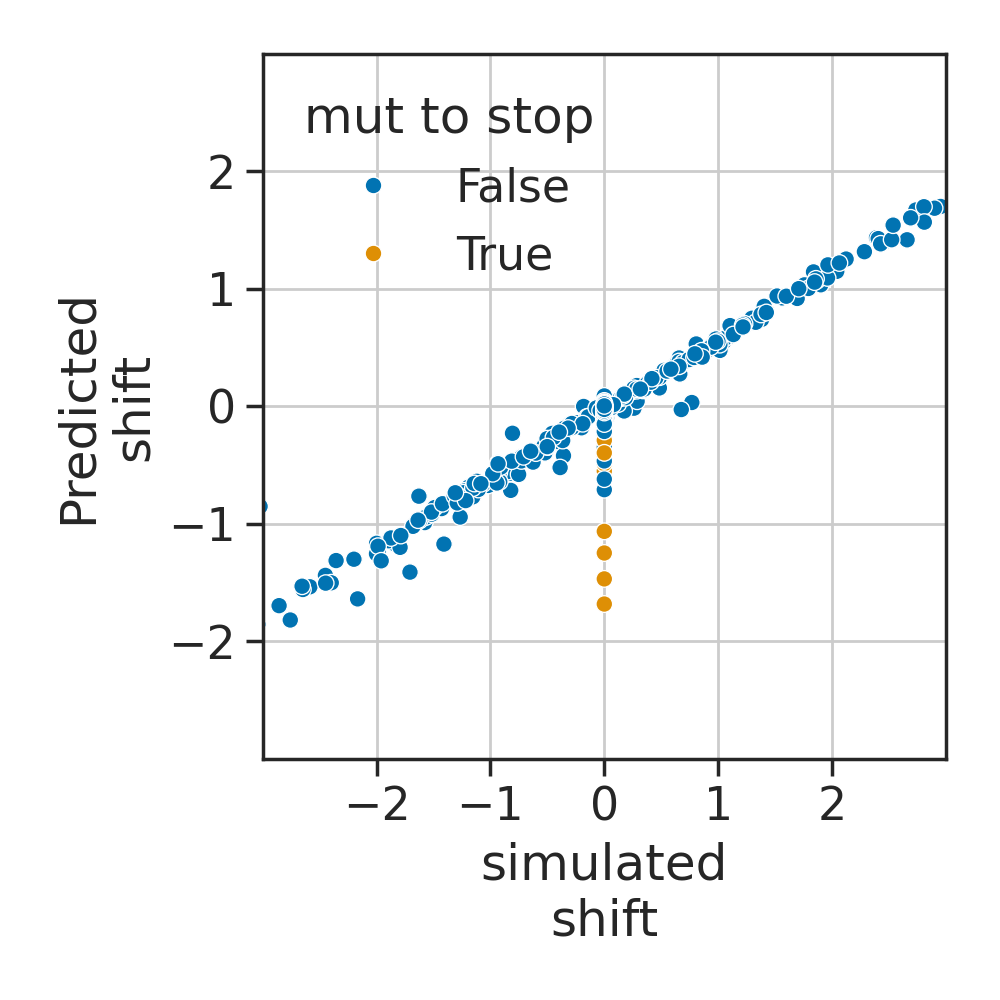

In [ ]:
# let's define a function that will take as model, and plot the scatter plot of model predictions vs. observed values
def plot_predictions_vs_observed(model, simulated_mut_effects=mut_effects_df, ax=None, **kwargs):
    """Plot scatter plot of model predictions vs. observed values"""
    if ax is None:
        fig, ax = plt.subplots(figsize=[5, 5])

    data = (
        model
        .get_mutations_df()[["shift_h2"]]
        .merge(
            simulated_mut_effects.set_index("mutation")[["shift"]],
            left_index=True,
            right_index=True,
        )
    )
    data = data.assign(is_stop=data.index.str.contains("\*"))
    
    sns.scatterplot(
        data=data,
        x="shift",
        y="shift_h2",
        hue="is_stop",
        ax=ax,
        **kwargs
    )

    ax.set_xlabel("simulated\nshift")
    ax.set(
        xlim=[-3, 3],
        xticks=[-2, -1, 0, 1, 2],
        ylim=[-3, 3],
        yticks=[-2, -1, 0, 1, 2],
    )
    ax.set_ylabel("Predicted\nshift")
    # ax.legend(title="Condition")
    return ax

ax = plot_predictions_vs_observed(fit_model.model)
# move legend outside and remove frame
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Stop codon", frameon=False)
ax.legend(title="mut to stop", frameon=False)
ax.grid()
plt.tight_layout()
plt.show()

The results generally look good. But it seems our model inherently wants to shift the stop codon to be negative. One reason this might be happening is that by default, we do not include the $\alpha_{d}$ parameter. Next, let's fot a collection of models across different lasso strengths, both with and without an $\alpha_{d}$ parameter.

In [ ]:
model_collection_params = {
    "dataset": list(data_objects.values()),
    "num_training_steps" : [10],
    "iterations_per_step": [1000], # Small number of iterations for purposes of this example
    # "alpha_d" : [False],
    # "scale_coeff_ridge_alpha_d": [1e-3, 0],
    "scale_coeff_lasso_shift": [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 3e-4],
}
_, _, fit_collection = multidms.model_collection.fit_models(model_collection_params, n_threads=24)

# from pprint import pprint
# pprint(multidms.model_collection._explode_params_dict(model_collection_params))

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun 

In [ ]:
fit_collection

model dataset_name  \
0   Model(Model-0)        lib_1   
1   Model(Model-0)        lib_1   
2   Model(Model-0)        lib_1   
3   Model(Model-0)        lib_1   
4   Model(Model-0)        lib_1   
5   Model(Model-0)        lib_1   
6   Model(Model-0)        lib_2   
7   Model(Model-0)        lib_2   
8   Model(Model-0)        lib_2   
9   Model(Model-0)        lib_2   
10  Model(Model-0)        lib_2   
11  Model(Model-0)        lib_2   

                                            step_loss epistatic_model  \
0   [0.03800628658479281, 0.011929736216532595, 0....         Sigmoid   
1   [0.038451964829851956, 0.01141095382441157, 0....         Sigmoid   
2   [0.03841149932076949, 0.010865311048572308, 0....         Sigmoid   
3   [0.04528741868266813, 0.011627262990412788, 0....         Sigmoid   
4   [0.05550014371425741, 0.016813124195880155, 0....         Sigmoid   
5   [0.06762825147919602, 0.02149183220268941, 0.0...         Sigmoid   
6   [0.03615704752653251, 0.011586937488626057, 0....         Sigmoid   
7   [0.0351922501560116, 0.010981501754515212, 0.0...         Sigmoid   
8   [7.358549686379124, 7.358549679384002, 7.35854...         Sigmoid   
9   [0.04558777418168942, 0.011206057808347441, 0....         Sigmoid   
10  [0.05559104743786724, 0.016095736726527934, 0....         Sigmoid   
11  [4.417674135429117, 4.335259945748278, 4.31399...         Sigmoid   

   output_activation scale_coeff_lasso_shift scale_coeff_ridge_beta  \
0           Identity                 0.00001                      0   
1           Identity                 0.00002                      0   
2           Identity                 0.00005                      0   
3           Identity                  0.0001                      0   
4           Identity                  0.0002                      0   
5           Identity                  0.0003                      0   
6           Identity                 0.00001                      0   
7           Identity                 0.00002                      0   
8           Identity                 0.00005                      0   
9           Identity                  0.0001                      0   
10          Identity                  0.0002                      0   
11          Identity                  0.0003                      0   

   scale_coeff_ridge_shift scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  \
0                        0                       0                         0   
1                        0                       0                         0   
2                        0                       0                         0   
3                        0                       0                         0   
4                        0                       0                         0   
5                        0                       0                         0   
6                        0                       0                         0   
7                        0                       0                         0   
8                        0                       0                         0   
9                        0                       0                         0   
10                       0                       0                         0   
11                       0                       0                         0   

    ... gamma_corrected alpha_d init_beta_naught lock_beta_naught_at     tol  \
0   ...           False   False              0.0                None  0.0001   
1   ...           False   False              0.0                None  0.0001   
2   ...           False   False              0.0                None  0.0001   
3   ...           False   False              0.0                None  0.0001   
4   ...           False   False              0.0                None  0.0001   
5   ...           False   False              0.0                None  0.0001   
6   ...           False   False              0.0                None  0.0001   
7 

In [ ]:
mc = multidms.model_collection.ModelCollection(fit_collection)


In [ ]:

# # query each combination of alpha_d and scale_coeff_ridge_alpha_d, plot like below
# charts = {}
# for alpha_d in [True, False]:
#     for scale_coeff_ridge_alpha_d in [1e-3, 0]:
#         charts[(alpha_d, scale_coeff_ridge_alpha_d)] = mc.shift_sparsity(
#             query=f"alpha_d=={alpha_d} and scale_coeff_ridge_alpha_d=={scale_coeff_ridge_alpha_d}",
#         )


# mc.shift_sparsity(query="alpha_d")

In [ ]:
mc.shift_sparsity()

cache miss - this could take a moment


alt.FacetChart(...)

In [ ]:
mc.mut_param_dataset_correlation(query="alpha_d==False and scale_coeff_ridge_alpha_d==0")

alt.FacetChart(...)

In [ ]:
for idx, row in fit_collection.query("alpha_d == False and scale_coeff_ridge_alpha_d == 0 and scale_coeff_lasso_shift == 0.0002")

model dataset_name  \
39  Model(Model-1)        lib_1   
55  Model(Model-2)        lib_2   

                                            step_loss epistatic_model  \
39  [0.036729639671896366, 0.014360320257118146, 0...         Sigmoid   
55  [0.03621408664280974, 0.01465432640750043, 0.0...         Sigmoid   

   output_activation scale_coeff_lasso_shift scale_coeff_ridge_beta  \
39          Identity                  0.0002                      0   
55          Identity                  0.0002                      0   

   scale_coeff_ridge_shift scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  \
39                       0                       0                         0   
55                       0                       0                         0   

    ... gamma_corrected alpha_d init_beta_naught lock_beta_naught_at     tol  \
39  ...           False   False              0.0                None  0.0001   
55  ...           False   False              0.0                None  0.0001   

   num_training_steps iterations_per_step n_hidden_units lower_bound PRNGKey  
39                 10                1000              5        None       0  
55                 10                1000              5        None       0  

[2 rows x 21 columns]

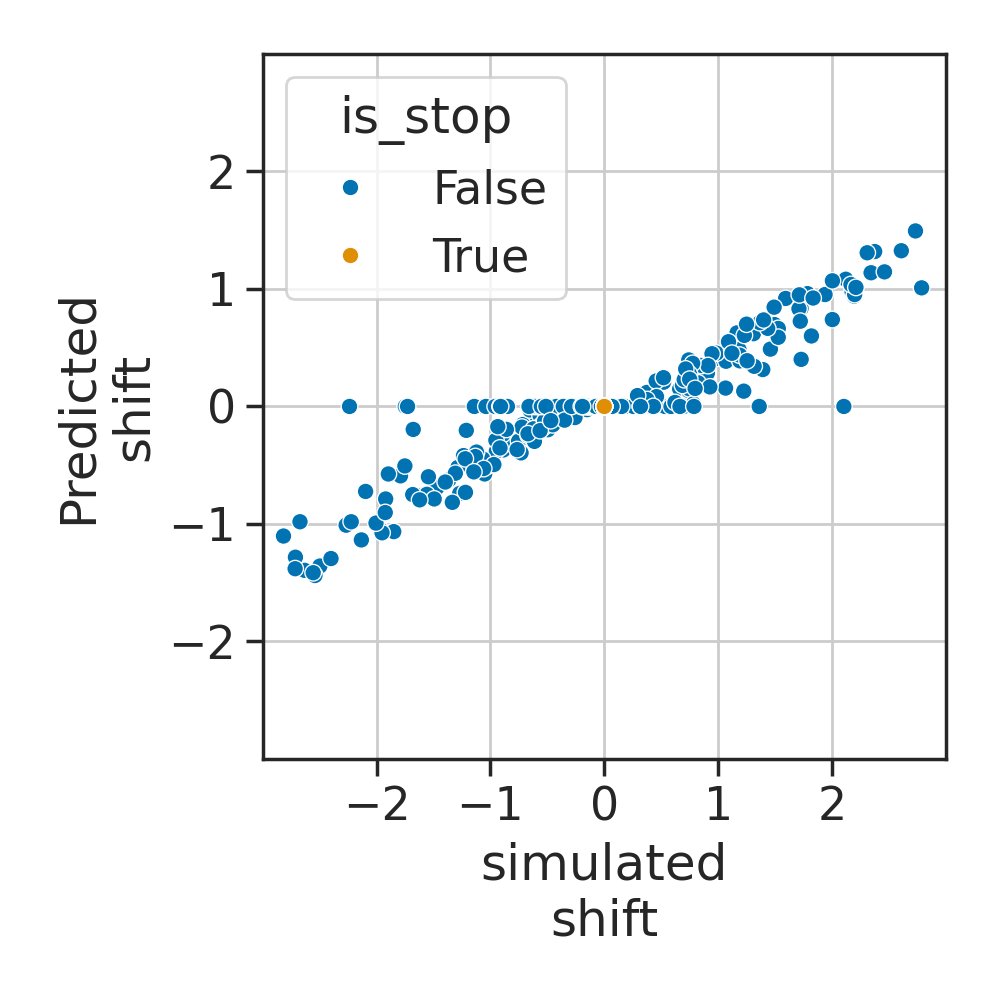

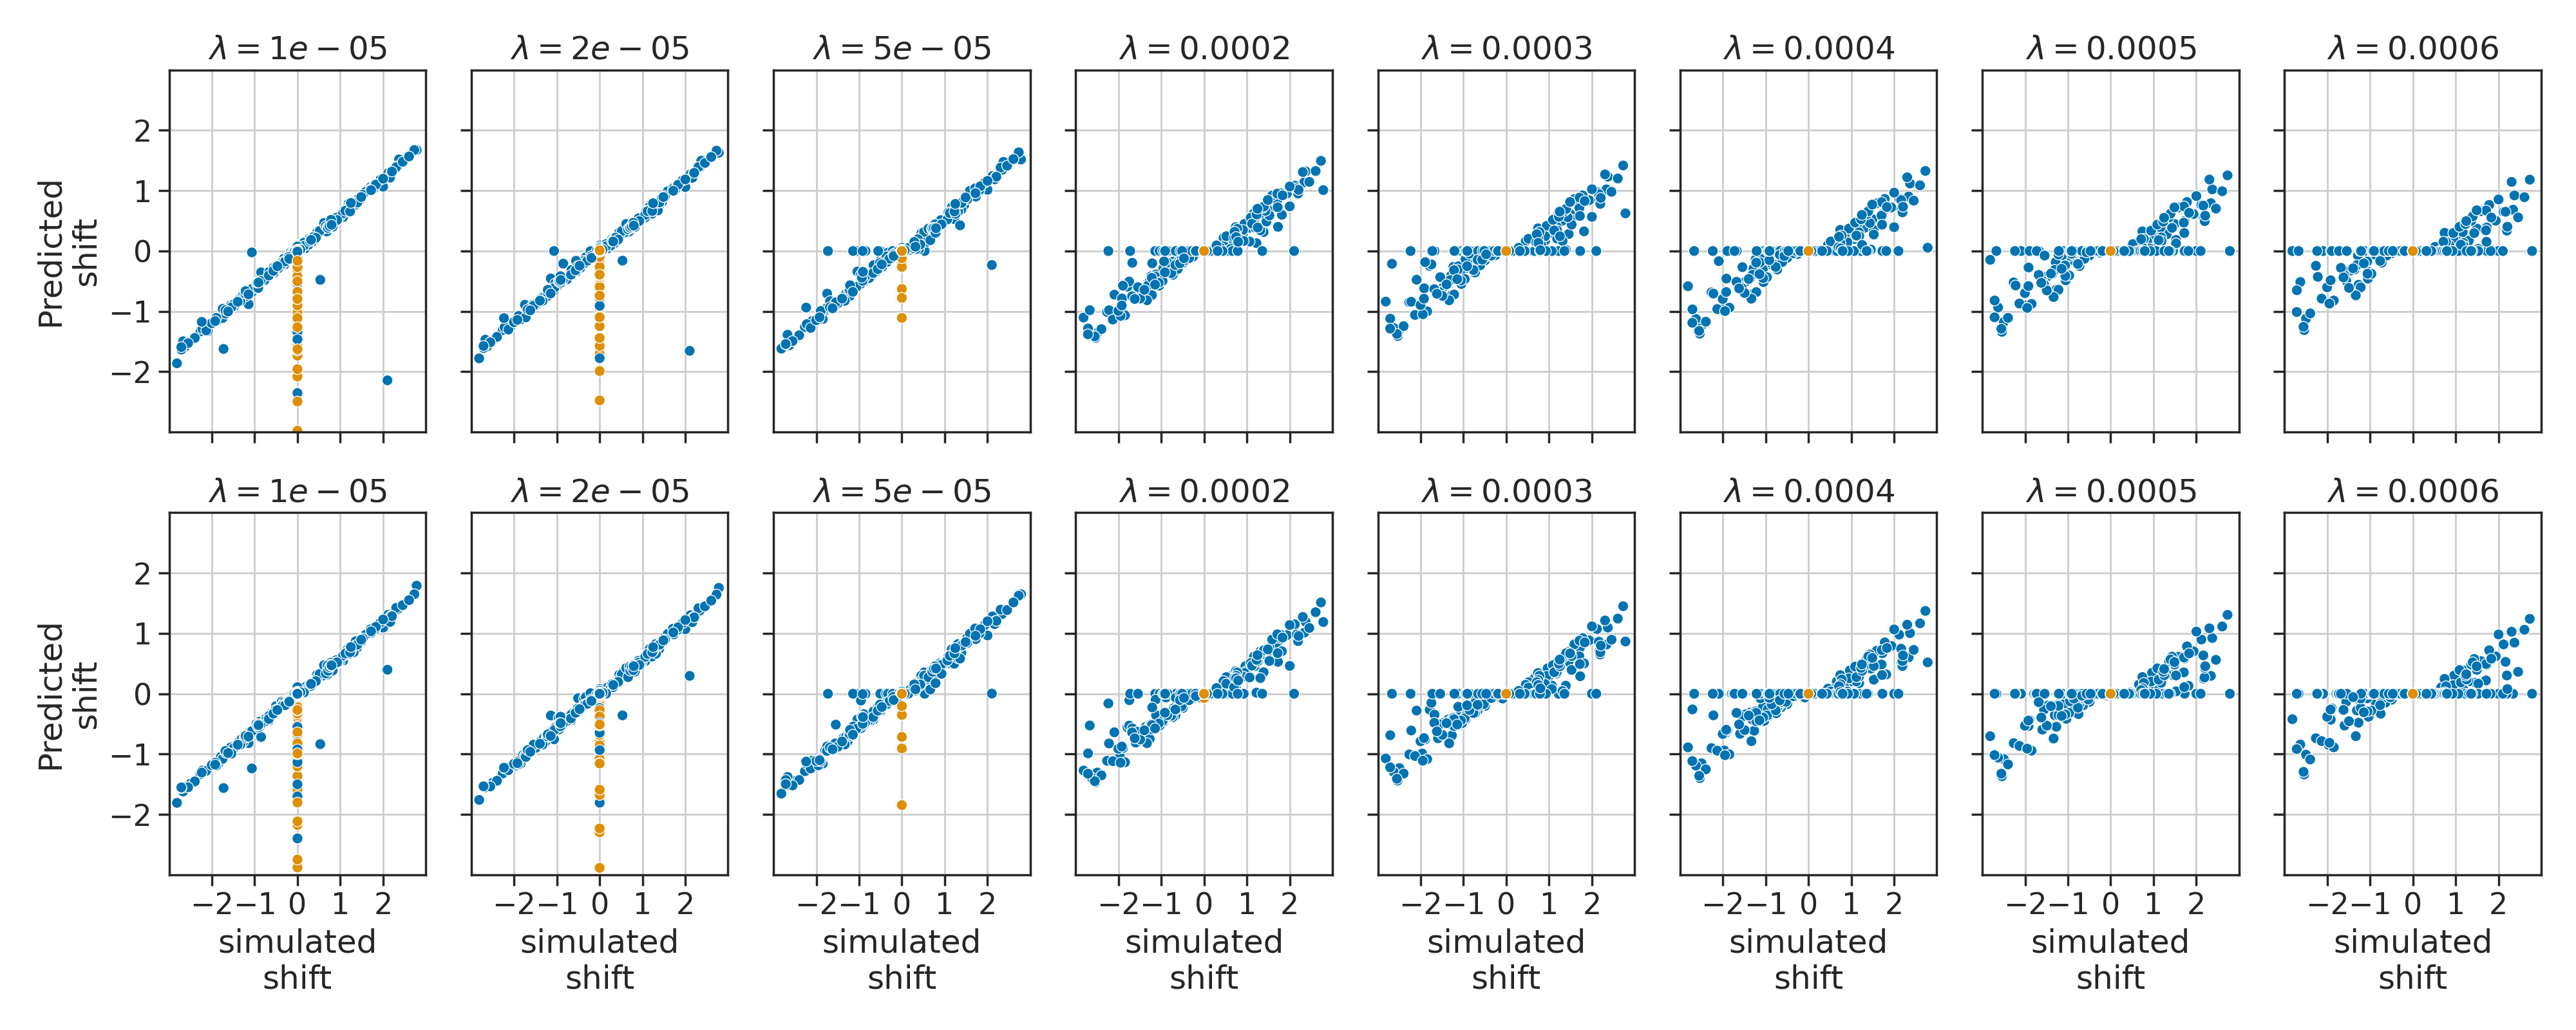

In [ ]:
fig, ax = plt.subplots(figsize=[5, 5])
plot_predictions_vs_observed(fit_collection.loc[39, "model"], ax=ax)
ax.grid()
plt.tight_layout()
plt.show()

alpha_d = False
scale_coeff_ridge_alpha_d = 0
plotting_fit_collection = fit_collection.query(
    f"alpha_d == {alpha_d} and scale_coeff_ridge_alpha_d == {scale_coeff_ridge_alpha_d}"
)
# now do  the same thing but make a subplot with rows for each of the unique possible datasets in plotting_fit_collection
# and columns for each of the possible scale_coeff_ridge_alpha_d
fig, ax = plt.subplots(
    nrows=len(plotting_fit_collection.dataset_name.unique()), 
    ncols=len(plotting_fit_collection.scale_coeff_lasso_shift.unique()), 
    figsize=[20, 8],
    sharex=True,
    sharey=True,
)
for row, dataset_name in enumerate(plotting_fit_collection.dataset_name.unique()):
    for col, scale_coeff_lasso_shift in enumerate(plotting_fit_collection.scale_coeff_lasso_shift.unique()):
        plot_predictions_vs_observed(
            plotting_fit_collection.query(
                f"dataset_name == '{dataset_name}' and scale_coeff_lasso_shift == {scale_coeff_lasso_shift}"
            ).model.values[0],
            ax=ax[row, col],
            legend=False
        )
        ax[row, col].grid()
        ax[row, col].set_title(f"$\lambda={scale_coeff_lasso_shift}$")
plt.tight_layout()
plt.show()


## The below code is me doing reality checks. Could think about making this more interpretable.

Show data for a mutation with identical effects between homologs.

In [ ]:
mutation = 'R1D'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + SigmoidPhenotype_h1.wt_latent, 2))
print('h2', round(beta_h2 + SigmoidPhenotype_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 -2.46
h2 -1.85

data from single-mutant variants:


/tmp/ipykernel_12477/1908913030.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/tmp/ipykernel_12477/1908913030.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


library           barcode  variant_call_support codon_substitutions  \
4350   lib_1  AGTACAATTGCATGAC                     3             AGA1GAT   

     aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
4350              R1D                      1                   1   

      latent_phenotype  observed_phenotype  observed_enrichment  
4350         -2.458668           -3.639199             0.080259

library           barcode  variant_call_support codon_substitutions  \
4350   lib_1  AGTACAATTGCATGAC                     3             AGA1GAT   

     aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
4350              R1D                      1                   1   

      latent_phenotype  observed_phenotype  observed_enrichment  
4350         -1.845728           -2.860021             0.137736

Show data for a mutation with a shifted effect at a site that is identical between homologs.

In [ ]:
mutation = 'V3W'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + SigmoidPhenotype_h1.wt_latent, 2))
print('h2', round(beta_h2 + SigmoidPhenotype_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 7.05
h2 10.45

data from single-mutant variants:


/tmp/ipykernel_12477/2463513129.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/tmp/ipykernel_12477/2463513129.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


library           barcode  variant_call_support codon_substitutions  \
4615   lib_1  AGTTACCCCGCTTTTT                     2    GTG3TGG AGT40TCG   

     aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
4615              V3W                      2                   1   

      latent_phenotype  observed_phenotype  observed_enrichment  
4615          7.046597            0.008425             1.005857

library           barcode  variant_call_support codon_substitutions  \
16747   lib_1  GGGTCCCCACTACTCA                     3             GTG3TGG   

      aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
16747              V3W                      1                   1   

       latent_phenotype  observed_phenotype  observed_enrichment  
16747         10.445533             0.00521             1.003618

Show data for a mutation with a shifted effect at a site that is non-identical between homologs.

In [ ]:
mutation = 'K17A'
v2_df = CodonVariantTable_h2.barcode_variant_df
v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1)

library           barcode  variant_call_support codon_substitutions  \
2224   lib_1  ACCGGCATTTTCGCTT                     3            AAG17GCC   

     aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
2224             K17A                      1                   1   

      latent_phenotype  observed_phenotype  observed_enrichment  
2224          7.209132            0.004186             1.002905

In [ ]:
mut_effects_df[
    mut_effects_df['mutation'].isin(['I17K', 'I17A'])
]

mutation   beta_h1 wt_aa  site mut_aa  shifted_site     shift   beta_h2  \
320     I17A  0.346554     I    17      A          True  1.182357  1.528911   
327     I17K  2.563328     I    17      K          True -2.630611 -0.067283   

    aaseq_h1 aaseq_h2  
320        I        K  
327        I        K

In [ ]:
SigmoidPhenotype_h2.wt_latent - (-0.067283) + 1.528911

7.209133034778654

In [ ]:
mutation = 'I17A'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + SigmoidPhenotype_h1.wt_latent, 2))
#print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 5.35

data from single-mutant variants:


/tmp/ipykernel_12477/4238188484.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/tmp/ipykernel_12477/4238188484.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


library           barcode  variant_call_support codon_substitutions  \
2224   lib_1  ACCGGCATTTTCGCTT                     3            ATC17GCC   

     aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
2224             I17A                      1                   1   

      latent_phenotype  observed_phenotype  observed_enrichment  
2224          5.346554            0.002828             1.001962

Empty DataFrame
Columns: [library, barcode, variant_call_support, codon_substitutions, aa_substitutions, n_codon_substitutions, n_aa_substitutions, latent_phenotype, observed_phenotype, observed_enrichment]
Index: []

In [ ]:
mutation = 'I17K'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + SigmoidPhenotype_h1.wt_latent, 2))
#print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 7.56

data from single-mutant variants:


/tmp/ipykernel_12477/1128934803.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
/tmp/ipykernel_12477/1128934803.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


library           barcode  variant_call_support codon_substitutions  \
1250   lib_1  AATAAGTGGGATATCG                     2            ATC17AAG   

     aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
1250             I17K                      1                   1   

      latent_phenotype  observed_phenotype  observed_enrichment  
1250          7.563328            0.008931             1.006209

Empty DataFrame
Columns: [library, barcode, variant_call_support, codon_substitutions, aa_substitutions, n_codon_substitutions, n_aa_substitutions, latent_phenotype, observed_phenotype, observed_enrichment]
Index: []

Show data for a mutation to the same amino acid at a site that is has no shifted mutational effects and is non-identical between homologs.

In [ ]:
mutation = 'V2F'
v2_df = CodonVariantTable_h2.barcode_variant_df
v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1)

library           barcode  variant_call_support codon_substitutions  \
366   lib_1  AAATAGGCGAGGAGGT                     1             GTA2TTC   

    aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
366              V2F                      1                   1   

     latent_phenotype  observed_phenotype  observed_enrichment  
366          2.402038           -0.119652              0.92041

In [ ]:
mut_effects_df[
    mut_effects_df['mutation'].isin(['S2V', 'S2F'])
]

mutation   beta_h1 wt_aa  site mut_aa  shifted_site  shift   beta_h2  \
24      S2F -2.027543     S     2      F         False    0.0 -2.027543   
36      S2V  1.183358     S     2      V         False    0.0  1.183358   

   aaseq_h1 aaseq_h2  
24        S        V  
36        S        V

In [ ]:
SigmoidPhenotype_h2.wt_latent + SigmoidPhenotype_h2.muteffects['V2F']

KeyError: 'V2F'

In [ ]:
mutation = 'S2F'
beta_h1 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h1'])
beta_h2 = float(mut_effects_df[mut_effects_df['mutation'] == mutation]['beta_h2'])
print('simulated latent phenotype:')
print('h1', round(beta_h1 + SigmoidPhenotype_h1.wt_latent, 2))
#print('h2', round(beta_h2 + p_sim_h2.wt_latent, 2))
print('\ndata from single-mutant variants:')
display(v1_df[
    (v1_df['n_aa_substitutions'] == 1) &
    (v1_df['aa_substitutions'].str.contains(mutation))
].head(n=1))
display(v2_df[
    (v2_df['n_aa_substitutions'] == 1) &
    (v2_df['aa_substitutions'].str.contains(mutation))
].head(n=1))

simulated latent phenotype:
h1 2.97

data from single-mutant variants:


library           barcode  variant_call_support codon_substitutions  \
366   lib_1  AAATAGGCGAGGAGGT                     1             TCC2TTC   

    aa_substitutions  n_codon_substitutions  n_aa_substitutions  \
366              S2F                      1                   1   

     latent_phenotype  observed_phenotype  observed_enrichment  
366          2.972457           -0.062254             0.957766

Empty DataFrame
Columns: [library, barcode, variant_call_support, codon_substitutions, aa_substitutions, n_codon_substitutions, n_aa_substitutions, latent_phenotype, observed_phenotype, observed_enrichment]
Index: []

In [ ]:
# Plot global-epistasis curves
# Make easier?

# Run through today
# Push
# Jared look over code

# Small test case
# Big test case

Question for Jesse:
* Say have two homologs separated by five mutations. Say have h1 + mutations that go to h2. Or have h2 + mutations that go to h1. In one case we'd add shifts, and in the other case we wouldn't. Problem?

In [ ]:
len(v1_df.query("library == 'lib_1'").barcode.unique()) == len(v1_df.query("library == 'lib_1'"))

True

In [ ]:
v1_df.head()

library           barcode  variant_call_support  \
0   lib_1  AAAAAAATTTACGCGA                     1   
1   lib_1  AAAAAACATAGGAGTA                     3   
2   lib_1  AAAAAAGAGGTTAAAC                     1   
3   lib_1  AAAAAAGGCTTATACT                     1   
4   lib_1  AAAAAATCACTAATAT                     3   

                           codon_substitutions    aa_substitutions  \
0                   TTA18GTC TTA23TCA TTT41AAC      L18V L23S F41N   
1                            TGC19AAG CGG29TCC           C19K R29S   
2                                     ATG32TTC                M32F   
3                   TCA11TCG CGG12GGT GGT46AAA           R12G G46K   
4  AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC  R1T R15P S37A S40*   

   n_codon_substitutions  n_aa_substitutions  latent_phenotype  \
0                      3                   3        -15.608947   
1                      2                   2          2.516825   
2                      1                   1          3.980341   
3                      3                   2        -21.146126   
4                      5                   4        -21.623836   

   observed_phenotype  observed_enrichment  
0           -9.965543             0.001000  
1           -0.102192             0.931616  
2           -0.016995             0.988289  
3           -9.965783             0.001000  
4           -9.965784             0.001000

In [ ]:
v2_df.head()

library           barcode  variant_call_support  \
0   lib_1  AAAAAAATTTACGCGA                     1   
1   lib_1  AAAAAACATAGGAGTA                     3   
2   lib_1  AAAAAAGAGGTTAAAC                     1   
3   lib_1  AAAAAAGGCTTATACT                     1   
4   lib_1  AAAAAATCACTAATAT                     3   

                           codon_substitutions         aa_substitutions  \
0                   TTA18GTC CGC23TCC TTT41AAC           L18V R23S F41N   
1                            TGC19AAG CGG29TCC                C19K R29S   
2                                     ATG32TTC                     M32F   
3                   TCA11TCG CGG12GGT GGT46AAA                R12G G46K   
4  AGA1ACA CGT15CCG TCC37GCT AAG40TAA CAC42AGC  R1T R15P S37A K40* H42S   

   n_codon_substitutions  n_aa_substitutions  latent_phenotype  \
0                      3                   3        -16.334070   
1                      2                   2          0.589252   
2                      1                   1          4.593280   
3                      3                   2        -20.533187   
4                      5                   5        -18.897776   

   observed_phenotype  observed_enrichment  
0           -9.965668             0.001000  
1           -0.630627             0.645896  
2           -0.009260             0.993602  
3           -9.965783             0.001000  
4           -9.965775             0.001000

In [ ]:
v1_df = v1_df.assign(homolog="reference")
v2_df = v2_df.assign(homolog="H2")
simulated_dataset = pd.concat([v1_df, v2_df])

In [ ]:
simulated_dataset

library           barcode  variant_call_support  \
0       lib_1  AAAAAAATTTACGCGA                     1   
1       lib_1  AAAAAACATAGGAGTA                     3   
2       lib_1  AAAAAAGAGGTTAAAC                     1   
3       lib_1  AAAAAAGGCTTATACT                     1   
4       lib_1  AAAAAATCACTAATAT                     3   
...       ...               ...                   ...   
49995   lib_2  TTTTTGTTCTCAACAG                     2   
49996   lib_2  TTTTTTCCACTTTACC                     4   
49997   lib_2  TTTTTTCTCTAGCTCA                     3   
49998   lib_2  TTTTTTCTTTATCTCT                     3   
49999   lib_2  TTTTTTGTCCATCAGC                     3   

                                     codon_substitutions  \
0                             TTA18GTC TTA23TCA TTT41AAC   
1                                      TGC19AAG CGG29TCC   
2                                               ATG32TTC   
3                             TCA11TCG CGG12GGT GGT46AAA   
4            AGA1ACA CGT15CCG TCC37GCT AGT40TAA TCG42AGC   
...                                                  ...   
49995                         ATA16GAG GCT39AAT CCA44GAA   
49996                                           GGT46TCA   
49997       AAA14ACG ATA16CGG AAC21CGG CCT24GGA ATC33CAC   
49998  GCT7TAC AAC20TCG GAC22GGG ATG31GCG GAC38TCT GC...   
49999                          CGT6CTA CGC26TGC ACT43GGG   

                        aa_substitutions  n_codon_substitutions  \
0                         L18V L23S F41N                      3   
1                              C19K R29S                      2   
2                                   M32F                      1   
3                              R12G G46K                      3   
4                     R1T R15P S37A S40*                      5   
...                                  ...                    ...   
49995                     I16E A39N P44E                      3   
49996                               G46S                      1   
49997           K14T I16R N21R P24G I33H                      5   
49998  A7Y N20S D22G M31A D38S A39N G46P                      7   
49999                      R6L R26C T43G                      3   

       n_aa_substitutions  latent_phenotype  observed_phenotype  \
0                       3        -15.608947           -9.965543   
1                       2          2.516825           -0.102192   
2                       1          3.980341           -0.016995   
3                       2        -21.146126           -9.965783   
4                       4        -21.623836           -9.965784   
...                   ...               ...                 ...   
49995                   3        -11.059277           -9.943194   
49996                   1         -1.222372           -2.125815   
49997                   5        -21.241232           -9.965783   
49998                   7        -35.439788           -9.965784   
49999                   3         -3.325291           -4.803673   

       observed_enrichment    homolog  
0                 0.001000  reference  
1                 0.931616  reference  
2                 0.988289  reference  
3                 0.001000  reference  
4                 0.001000  reference  
...                    ...        ...  
49995             0.001016         H2  
49996             0.229122         H2  
49997             0.001000         H2  
49998             0.001000         H2  
49999             0.035806         H2  

[100000 rows x 11 columns]

In [ ]:
! mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
simulated_dataset.to_csv(f"results/simulated_dataset_v1.csv", index=False)

In [ ]:
geneseq_h1

'AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA'

In [ ]:
geneseq_h2

'AGAGTAGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTATAAAGTTATGCAACAACGACCGCCCTATCCGCAACATCCGGACAATGATGATCGAACACAACTCCGACGCTAAGTTTCACACTCCATATGGTTTAGACTCAGGA'

In [ ]:
homolog_seqs

{1: 'RSVILRAYTNSRVKRVILCNNDLPIRNIRLMMILHNSDASFSTPVGLRSG',
 2: 'RVVILRAYTNSRVKRIKLCNNDRPIRNIRTMMIEHNSDAKFHTPYGLDSG'}

In [ ]:
import json
help(json.dump)

Help on function dump in module json:

dump(obj, fp, *, skipkeys=False, ensure_ascii=True, check_circular=True, allow_nan=True, cls=None, indent=None, separators=None, default=None, sort_keys=False, **kw)
    Serialize ``obj`` as a JSON formatted stream to ``fp`` (a
    ``.write()``-supporting file-like object).
    
    If ``skipkeys`` is true then ``dict`` keys that are not basic types
    (``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
    instead of raising a ``TypeError``.
    
    If ``ensure_ascii`` is false, then the strings written to ``fp`` can
    contain non-ASCII characters if they appear in strings contained in
    ``obj``. Otherwise, all such characters are escaped in JSON strings.
    
    If ``check_circular`` is false, then the circular reference check
    for container types will be skipped and a circular reference will
    result in an ``RecursionError`` (or worse).
    
    If ``allow_nan`` is false, then it will be a ``ValueError`` to
    seriali

In [ ]:
import json
json.dump(homolog_seqs, open("results/homolog_aa_seqs.json", "w"))